In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Import models and tools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    RandomForestRegressor, BaggingRegressor,
    AdaBoostRegressor, GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
# ==========================================
# Data Reading and Initial Preparation
# ==========================================

# Read the data
df = pd.read_csv("not_final3.csv")

# List of parameters to process
parameters = ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV']

# For 'normalized_country' and 'CV', we need to split at 2000 instead of 2004
split_years = {
    'normalized_country': 2000,
    'CV': 2000
}

# For other parameters, split at 2004
default_split_year = 2004

# For 'drug', missing values should be filled with 0
fill_missing_with_zero = ['drug']


In [3]:
# # Iterate over each parameter
# for parameter in parameters:
#     print(f"\nProcessing parameter: {parameter}")
#     print("=" * 50)
    
#     # ==========================================
#     # Data Preparation
#     # ==========================================
    
#     # Filter columns for the current parameter
#     param_columns = [col for col in df.columns if col.split('_')[0] == parameter]
    
#     # Include 'Sport_-1' column as an identifier if it exists
#     if 'Sport_-1' in df.columns:
#         param_columns.insert(0, 'Sport_-1')
    
#     df_param = df[param_columns]
    
#     # Remove 'Sport_-1' column (identifier)
#     if 'Sport_-1' in df_param.columns:
#         df_param = df_param.rename(columns={'Sport_-1': 'Sport'})
#     else:
#         df_param['Sport'] = df['Sport_-1']
    
#     # Melt the data to long format
#     melted_data = df_param.reset_index().melt(id_vars=['index', 'Sport'], var_name='Year', value_name='Target')
    
#     # Extract the year from the 'parameter_year' format
#     melted_data['Year'] = melted_data['Year'].str.extract('(\d+)').astype(int)
    
#     # Handle missing values
#     if parameter in fill_missing_with_zero:
#         # Fill missing Target values with 0
#         melted_data['Target'] = melted_data['Target'].fillna(0)
#     else:
#         # For other parameters, fill missing values with -1
#         melted_data['Target'] = melted_data['Target'].fillna(-1)
    
#     # Sort by index and Year
#     melted_data = melted_data.sort_values(by=['index', 'Year']).reset_index(drop=True)
    
#     # Function to create rolling window lags
#     def create_lags(group):
#         group['Lag_1'] = group['Target'].shift(1, fill_value=-1)
#         group['Lag_2'] = group['Target'].shift(2, fill_value=-1)
#         group['Lag_3'] = group['Target'].shift(3, fill_value=-1)
#         return group
    
#     # Apply rolling window logic for each sport (index)
#     result = melted_data.groupby('index').apply(create_lags).reset_index(drop=True)
    
#     # Define function to fill missing lags
#     def fill_lags(row):
#         # Fill missing lags using available lower lags
#         for lag in ['Lag_1', 'Lag_2', 'Lag_3']:
#             if row[lag] == -1:
#                 lower_lags = [l for l in ['Lag_1', 'Lag_2', 'Lag_3'] if row[l] != -1 and l > lag]
#                 if lower_lags:
#                     row[lag] = row[lower_lags[0]]  # Use the most recent lower lag value
#         return row
    
#     # Apply the lag-filling function to each group
#     result = result.groupby('index').apply(lambda group: group.apply(fill_lags, axis=1)).reset_index(drop=True)
    
#     # Drop rows with -1 in any of the columns: 'Target', 'Lag_1', 'Lag_2', 'Lag_3'
#     cleaned_result = result[(result[['Target', 'Lag_1', 'Lag_2', 'Lag_3']] != -1).all(axis=1)].reset_index(drop=True)
    
#     # Determine split year
#     split_year = split_years.get(parameter, default_split_year)
    
#     # Divide the DataFrame into two based on the Year column
#     before_split = cleaned_result[cleaned_result['Year'] < split_year].reset_index(drop=True)
#     after_or_equal_split = cleaned_result[cleaned_result['Year'] >= split_year].reset_index(drop=True)
#     print("\nData after cleaning and before modeling:")
#     print(cleaned_result.head())

    
#     # ==========================================
#     # EDA (Exploratory Data Analysis)
#     # ==========================================
    
#     print(f"\nData before {split_year}: {before_split.shape}")
#     print(f"Data from {split_year} onwards: {after_or_equal_split.shape}")
    
#     # Drop 'index' and 'Sport' columns for modeling
#     X_train = before_split.drop(['Target', 'index', 'Sport'], axis=1)
#     y_train = before_split['Target']
    
#     X_test = after_or_equal_split.drop(['Target', 'index', 'Sport'], axis=1)
#     y_test = after_or_equal_split['Target']
    
#     # Visualize data
#     def visualize_data(X, y, title=""):
#         print(f"\n{title} - Descriptive Statistics")
#         print(X.describe())
#         print(f"\n{title} Target Variable - Descriptive Statistics")
#         print(y.describe())
        
#         plt.figure(figsize=(10, 6))
#         plt.plot(y.values, label="Target")
#         plt.title(f"{title} Target Variable for {parameter}")
#         plt.legend()
#         plt.show()
    
#     # Visualizing train/test data
#     visualize_data(X_train, y_train, "Training Data")
#     visualize_data(X_test, y_test, "Test Data")
    
#     # Pairplot
#     combined_data = pd.concat([X_train, y_train], axis=1)
#     sns.pairplot(combined_data, diag_kind='kde')
#     plt.suptitle(f'Pair Plot for Features (Train Data) - {parameter}', y=1.02)
#     plt.show()
    
#     # Correlation Heatmap
#     plt.figure(figsize=(10, 6))
#     correlation = combined_data.corr()
#     sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#     plt.title(f"Feature Correlation Heatmap - {parameter}")
#     plt.show()
    
#     # Feature Importance using RandomForest
#     rf = RandomForestRegressor(n_estimators=100, random_state=42)
#     rf.fit(X_train, y_train)
#     importances = rf.feature_importances_
    
#     feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
#     feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
#     plt.title(f'Feature Importance using RandomForest - {parameter}')
#     plt.show()
    
#     # Principal Component Analysis (PCA) to reduce dimensions and visualize
#     pca = PCA(n_components=2)
#     X_train_pca = pca.fit_transform(X_train)
    
#     plt.figure(figsize=(10, 6))
#     plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
#     plt.title(f'PCA of Training Data - {parameter}')
#     plt.xlabel('First Principal Component')
#     plt.ylabel('Second Principal Component')
#     plt.colorbar(label='Target')
#     plt.show()
    
#     # ==========================================
#     # Time Series Analysis (for Rolling Windows)
#     # ==========================================
    
#     # Rolling Mean and Standard Deviation
#     def plot_rolling_stats(series, window=5, title="Rolling Mean and Standard Deviation"):
#         rolling_mean = series.rolling(window=window).mean()
#         rolling_std = series.rolling(window=window).std()
        
#         plt.figure(figsize=(12, 6))
#         plt.plot(series.values, label='Original', color='blue')
#         plt.plot(rolling_mean.values, label=f'Rolling Mean (window={window})', color='orange')
#         plt.plot(rolling_std.values, label=f'Rolling Std (window={window})', color='green')
#         plt.legend(loc='best')
#         plt.title(title)
#         plt.show()
    
#     # Augmented Dickey-Fuller Test for Stationarity
#     def test_stationarity(series, window=5):
#         print(f"Results of Dickey-Fuller Test:")
#         result = adfuller(series)
#         print(f"Test Statistic: {result[0]}")
#         print(f"p-value: {result[1]}")
#         print(f"Critical Values:")
#         for key, value in result[4].items():
#             print(f"   {key}: {value}")
            
#         plot_rolling_stats(series, window, title=f"Rolling Statistics for {parameter}")
        
#     # Autocorrelation and Partial Autocorrelation
#     def plot_acf_pacf(series, lags=20):
#         plt.figure(figsize=(12, 6))
#         plt.subplot(121)
#         plot_acf(series, lags=lags, ax=plt.gca(), title="Autocorrelation")
#         plt.subplot(122)
#         plot_pacf(series, lags=lags, ax=plt.gca(), title="Partial Autocorrelation")
#         plt.tight_layout()
#         plt.show()
    
#     print("\nStationarity Test and Rolling Statistics for Target Variable:")
#     test_stationarity(y_train)
    
#     print("\nAutocorrelation and Partial Autocorrelation for Target Variable:")
#     plot_acf_pacf(y_train)
    
#     # ==========================================
#     # Model Training and Evaluation
#     # ==========================================
    
#     # Initialize list to store results
#     results = []
    
#     # Define the list of models and their parameter grids
#     models = [
#         {
#             'name': 'CatBoost',
#             'estimator': CatBoostRegressor(random_state=42, verbose=0),
#             'param_grid': {
#                 'depth': [4, 6],
#                 'learning_rate': [0.01, 0.05],
#                 'iterations': [100]
#             }
#         },
#         {
#             'name': 'Random Forest',
#             'estimator': RandomForestRegressor(random_state=42),
#             'param_grid': {
#                 'n_estimators': [50, 100],
#                 'max_depth': [None, 5],
#                 'min_samples_split': [2, 5]
#             }
#         },
#         {
#             'name': 'Decision Tree',
#             'estimator': DecisionTreeRegressor(random_state=42),
#             'param_grid': {
#                 'max_depth': [None, 5, 10],
#                 'min_samples_split': [2, 5]
#             }
#         },
#         {
#             'name': 'k-NN Regression',
#             'estimator': KNeighborsRegressor(),
#             'param_grid': {
#                 'n_neighbors': [3, 5],
#                 'weights': ['uniform', 'distance']
#             }
#         },
#         {
#             'name': 'XGBoost',
#             'estimator': XGBRegressor(random_state=42, verbosity=0),
#             'param_grid': {
#                 'n_estimators': [100],
#                 'max_depth': [3, 5],
#                 'learning_rate': [0.01, 0.05]
#             }
#         },
#         {
#             'name': 'LightGBM',
#             'estimator': LGBMRegressor(random_state=42),
#             'param_grid': {
#                 'num_leaves': [31, 50],
#                 'learning_rate': [0.01, 0.05],
#                 'n_estimators': [100]
#             }
#         },
#         {
#             'name': 'Bagging',
#             'estimator': BaggingRegressor(random_state=42),
#             'param_grid': {
#                 'n_estimators': [10, 50],
#                 'max_samples': [0.5, 1.0],
#                 'max_features': [0.5, 1.0]
#             }
#         },
#         {
#             'name': 'AdaBoost',
#             'estimator': AdaBoostRegressor(random_state=42),
#             'param_grid': {
#                 'n_estimators': [50, 100],
#                 'learning_rate': [0.01, 0.05, 1.0]
#             }
#         },
#         {
#             'name': 'Gradient Boosting',
#             'estimator': GradientBoostingRegressor(random_state=42),
#             'param_grid': {
#                 'n_estimators': [100],
#                 'learning_rate': [0.01, 0.05],
#                 'max_depth': [3, 5]
#             }
#         },
#         # {
#         #     'name': 'SVR',
#         #     'estimator': SVR(),
#         #     'param_grid': {
#         #         'C': [0.5],        # Narrow range for regularization strength
#         #         'epsilon': [0.1],  # Fixed epsilon to avoid unnecessary grid search
#         #         'kernel': ['linear'],
#         #         'tol': [0.03]      # Increase tolerance for quicker convergence
#         #     }
#         # }
#     ]
    
#     # Loop over each model
#     for model_dict in models:
#         name = model_dict['name']
#         estimator = model_dict['estimator']
#         param_grid = model_dict['param_grid']
        
#         print(f"\nTraining {name}...")
        
#         # Set up GridSearchCV
#         grid_search = GridSearchCV(
#             estimator=estimator,
#             param_grid=param_grid,
#             cv=5,
#             n_jobs=-1,
#             scoring='neg_mean_squared_error'
#         )
        
#         # Fit the model
#         grid_search.fit(X_train, y_train)
        
#         # Retrieve the best parameters and estimator
#         best_params = grid_search.best_params_
#         best_estimator = grid_search.best_estimator_
        
#         # Make predictions on the test set
#         y_pred = best_estimator.predict(X_test)
        
#         # Evaluate the model
#         mse = mean_squared_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)
        
#         print(f"{name} - Best Params: {best_params}")
#         print(f"{name} - MSE: {mse}, R2: {r2}")
        
#         # Store the results
#         results.append({
#             'Model': name,
#             'Best Params': best_params,
#             'MSE': mse,
#             'R2': r2
#         })
    
#     # ==========================================
#     # Training Stacking Regressor
#     # ==========================================
    
#     # Define base estimators for stacking
#     estimators_list = [
#         ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
#         ('knn', KNeighborsRegressor(n_neighbors=5)),
#         ('dt', DecisionTreeRegressor(max_depth=5, random_state=42))
#     ]
    
#     # Define the final estimator
#     final_estimator = LinearRegression()
    
#     # Create the Stacking Regressor
#     stacking_model = StackingRegressor(
#         estimators=estimators_list,
#         final_estimator=final_estimator,
#         cv=5,
#         n_jobs=-1
#     )
    
#     print("\nTraining Stacking Regressor...")
    
#     # Define parameter grid for the stacking model
#     param_grid = {
#         'final_estimator__fit_intercept': [True, False]
#     }
    
#     # Set up GridSearchCV for the stacking model
#     grid_search = GridSearchCV(
#         estimator=stacking_model,
#         param_grid=param_grid,
#         cv=5,
#         n_jobs=-1,
#         scoring='neg_mean_squared_error'
#     )
    
#     # Fit the stacking model
#     grid_search.fit(X_train, y_train)
    
#     # Retrieve best parameters and estimator
#     best_params = grid_search.best_params_
#     best_estimator = grid_search.best_estimator_
    
#     # Make predictions on the test set
#     y_pred = best_estimator.predict(X_test)
    
#     # Evaluate the stacking model
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
    
#     print(f"Stacking Regressor - Best Params: {best_params}")
#     print(f"Stacking Regressor - MSE: {mse}, R2: {r2}")
    
#     # Store the results
#     results.append({
#         'Model': 'Stacking Regressor',
#         'Best Params': best_params,
#         'MSE': mse,
#         'R2': r2
#     })
    
#     # ==========================================
#     # Results Comparison
#     # ==========================================
    
#     # Create a DataFrame from the results
#     results_df = pd.DataFrame(results)
    
#     print("\nModel Evaluation Results:")
#     print(results_df)
    
#     # Plot MSE for each model
#     plt.figure(figsize=(10, 6))
#     plt.barh(results_df['Model'], results_df['MSE'], color='skyblue')
#     plt.xlabel('Mean Squared Error (MSE)')
#     plt.title(f'Model Comparison based on MSE - {parameter}')
#     plt.gca().invert_yaxis()
#     plt.tight_layout()
#     plt.show()
    
#     # Plot R^2 scores for each model
#     plt.figure(figsize=(10, 6))
#     plt.barh(results_df['Model'], results_df['R2'], color='salmon')
#     plt.xlabel('R^2 Score')
#     plt.title(f'Model Comparison based on R^2 Score - {parameter}')
#     plt.gca().invert_yaxis()
#     plt.tight_layout()
#     plt.show()

In [4]:
# # Ensure all necessary libraries are imported
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # For model training and evaluation
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# # Models
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression

# # Add this to your imports if not already present
# from sklearn.ensemble import StackingRegressor

# # Other necessary imports (from previous code)
# # ...

# # Proceed with the code for 'CV' parameter
# parameter = 'CV'
# print(f"\nProcessing parameter: {parameter}")
# print("=" * 50)

# # ==========================================
# # Data Preparation
# # ==========================================

# # Filter columns for the 'CV' parameter
# param_columns = [col for col in df.columns if col.split('_')[0] == parameter]

# # Include 'Sport_-1' column as an identifier if it exists
# if 'Sport_-1' in df.columns:
#     param_columns.insert(0, 'Sport_-1')

# df_param = df[param_columns]

# # Remove 'Sport_-1' column (identifier)
# if 'Sport_-1' in df_param.columns:
#     df_param = df_param.rename(columns={'Sport_-1': 'Sport'})
# else:
#     df_param['Sport'] = df['Sport_-1']

# # Melt the data to long format
# melted_data = df_param.reset_index().melt(id_vars=['index', 'Sport'], var_name='Year', value_name='Target')

# # Extract the year from the 'CV_year' format
# melted_data['Year'] = melted_data['Year'].str.extract('(\d+)').astype(int)

# # Handle missing values (fill with -1)
# melted_data['Target'] = melted_data['Target'].fillna(-1)

# # Sort by index and Year
# melted_data = melted_data.sort_values(by=['index', 'Year']).reset_index(drop=True)

# # Function to create rolling window lags
# def create_lags(group):
#     group['Lag_1'] = group['Target'].shift(1, fill_value=-1)
#     group['Lag_2'] = group['Target'].shift(2, fill_value=-1)
#     group['Lag_3'] = group['Target'].shift(3, fill_value=-1)
#     return group

# # Apply rolling window logic for each sport (index)
# result = melted_data.groupby('index').apply(create_lags).reset_index(drop=True)

# # Define function to fill missing lags
# def fill_lags(row):
#     # Fill missing lags using available lower lags
#     for lag in ['Lag_1', 'Lag_2', 'Lag_3']:
#         if row[lag] == -1:
#             lower_lags = [l for l in ['Lag_1', 'Lag_2', 'Lag_3'] if row[l] != -1 and l > lag]
#             if lower_lags:
#                 row[lag] = row[lower_lags[0]]  # Use the most recent lower lag value
#     return row

# # Apply the lag-filling function to each group
# result = result.groupby('index').apply(lambda group: group.apply(fill_lags, axis=1)).reset_index(drop=True)

# # Drop rows with -1 in any of the columns: 'Target', 'Lag_1', 'Lag_2', 'Lag_3'
# cleaned_result = result[(result[['Target', 'Lag_1', 'Lag_2', 'Lag_3']] != -1).all(axis=1)].reset_index(drop=True)

# # Print the head of the cleaned_result DataFrame
# print("\nData after cleaning and before modeling:")
# print(cleaned_result.head())

# # Determine split year (2000 for 'CV')
# split_year = split_years.get(parameter, default_split_year)

# # Divide the DataFrame into two based on the Year column
# before_split = cleaned_result[cleaned_result['Year'] < split_year].reset_index(drop=True)
# after_or_equal_split = cleaned_result[cleaned_result['Year'] >= split_year].reset_index(drop=True)

# # ==========================================
# # EDA (Exploratory Data Analysis)
# # ==========================================

# print(f"\nData before {split_year}: {before_split.shape}")
# print(f"Data from {split_year} onwards: {after_or_equal_split.shape}")

# # Drop 'index' and 'Sport' columns for modeling
# X_train = before_split.drop(['Target', 'index', 'Sport'], axis=1)
# y_train = before_split['Target']

# X_test = after_or_equal_split.drop(['Target', 'index', 'Sport'], axis=1)
# y_test = after_or_equal_split['Target']

# # ==========================================
# # Model Training and Evaluation
# # ==========================================

# # For simplicity, we'll use RandomForestRegressor here
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = rf.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"\nRandom Forest - MSE: {mse}, R2: {r2}")

# # ==========================================
# # Plotting Actual vs. Predicted Values for a Sport
# # ==========================================

# # Identify the sport with the most non-empty values in 'CV'
# # We'll use the original melted_data DataFrame
# non_empty_counts = melted_data[melted_data['Target'] != -1].groupby('Sport').size()
# most_data_sport = non_empty_counts.idxmax()
# print(f"\nSport with the most non-empty CV values: {most_data_sport}")

# # Filter test data for the selected sport
# sport_index = melted_data[melted_data['Sport'] == most_data_sport]['index'].unique()[0]

# # Get the rows corresponding to the selected sport in the test set
# sport_test_data = after_or_equal_split[after_or_equal_split['index'] == sport_index].reset_index(drop=True)

# # If sport_test_data is empty (no test data for that sport), pick another sport
# if sport_test_data.empty:
#     print(f"No test data available for sport: {most_data_sport}. Selecting another sport.")
#     # Remove sports without test data
#     valid_sports = after_or_equal_split['Sport'].unique()
#     non_empty_counts = non_empty_counts[non_empty_counts.index.isin(valid_sports)]
#     most_data_sport = non_empty_counts.idxmax()
#     print(f"New sport selected: {most_data_sport}")
#     sport_index = melted_data[melted_data['Sport'] == most_data_sport]['index'].unique()[0]
#     sport_test_data = after_or_equal_split[after_or_equal_split['index'] == sport_index].reset_index(drop=True)

# # Prepare data for plotting
# X_sport_test = sport_test_data.drop(['Target', 'index', 'Sport'], axis=1)
# y_sport_test = sport_test_data['Target']

# # Make predictions for the selected sport
# y_sport_pred = rf.predict(X_sport_test)

# # Create a DataFrame for plotting
# plot_df = pd.DataFrame({
#     'Actual': y_sport_test.values,
#     'Predicted': y_sport_pred
# })

# # Plot the data
# plt.figure(figsize=(10, 6))
# plt.plot(plot_df['Actual'], label='Actual CV')
# plt.plot(plot_df['Predicted'], label='Predicted CV', linestyle='--')
# plt.title(f'Actual vs. Predicted CV Values for {most_data_sport}')
# plt.xlabel('Sample Index')
# plt.ylabel('CV Value')
# plt.legend()
# plt.tight_layout()
# plt.show()



Processing parameter: drug

Data after cleaning and before modeling:
   index          Sport  Year  Target  Lag_1  Lag_2  Lag_3
0      0  Alpine Skiing  1906     0.0    0.0    0.0    0.0
1      0  Alpine Skiing  1908     0.0    0.0    0.0    0.0
2      0  Alpine Skiing  1912     0.0    0.0    0.0    0.0
3      0  Alpine Skiing  1920     0.0    0.0    0.0    0.0
4      0  Alpine Skiing  1924     0.0    0.0    0.0    0.0

Data before 2004: (1496, 7)
Data from 2004 onwards: (408, 7)

Training Data - Descriptive Statistics
              Year        Lag_1        Lag_2        Lag_3
count  1496.000000  1496.000000  1496.000000  1496.000000
mean   1954.636364     0.037433     0.032754     0.027406
std      29.362755     0.395547     0.352151     0.322901
min    1906.000000     0.000000     0.000000     0.000000
25%    1928.000000     0.000000     0.000000     0.000000
50%    1958.000000     0.000000     0.000000     0.000000
75%    1980.000000     0.000000     0.000000     0.000000
max    200

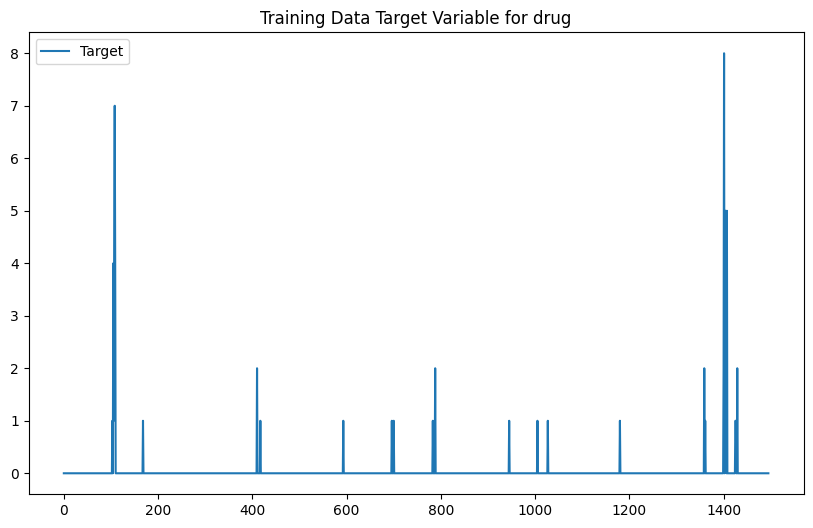


Test Data - Descriptive Statistics
              Year       Lag_1       Lag_2       Lag_3
count   408.000000  408.000000  408.000000  408.000000
mean   2014.000000    0.754902    0.745098    0.723039
std       6.839688    5.451932    5.451932    5.447021
min    2004.000000    0.000000    0.000000    0.000000
25%    2008.000000    0.000000    0.000000    0.000000
50%    2014.000000    0.000000    0.000000    0.000000
75%    2020.000000    0.000000    0.000000    0.000000
max    2024.000000   86.000000   86.000000   86.000000

Test Data Target Variable - Descriptive Statistics
count    408.000000
mean       0.735294
std        5.446053
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       86.000000
Name: Target, dtype: float64


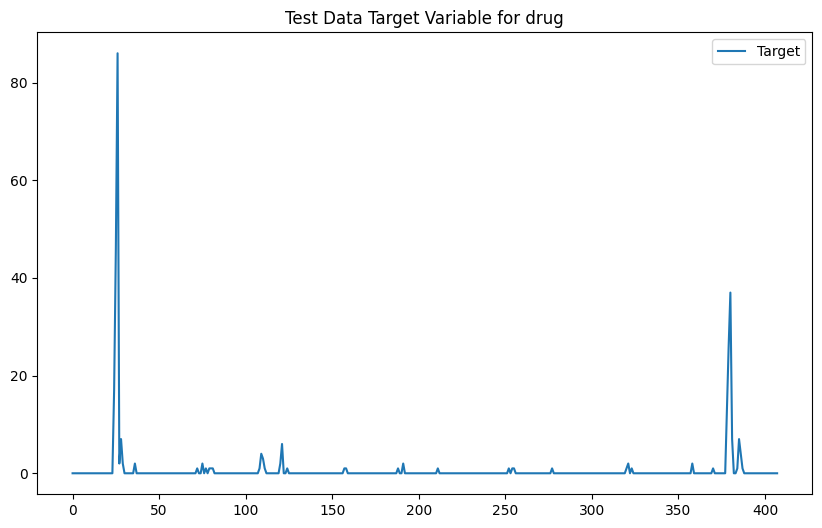

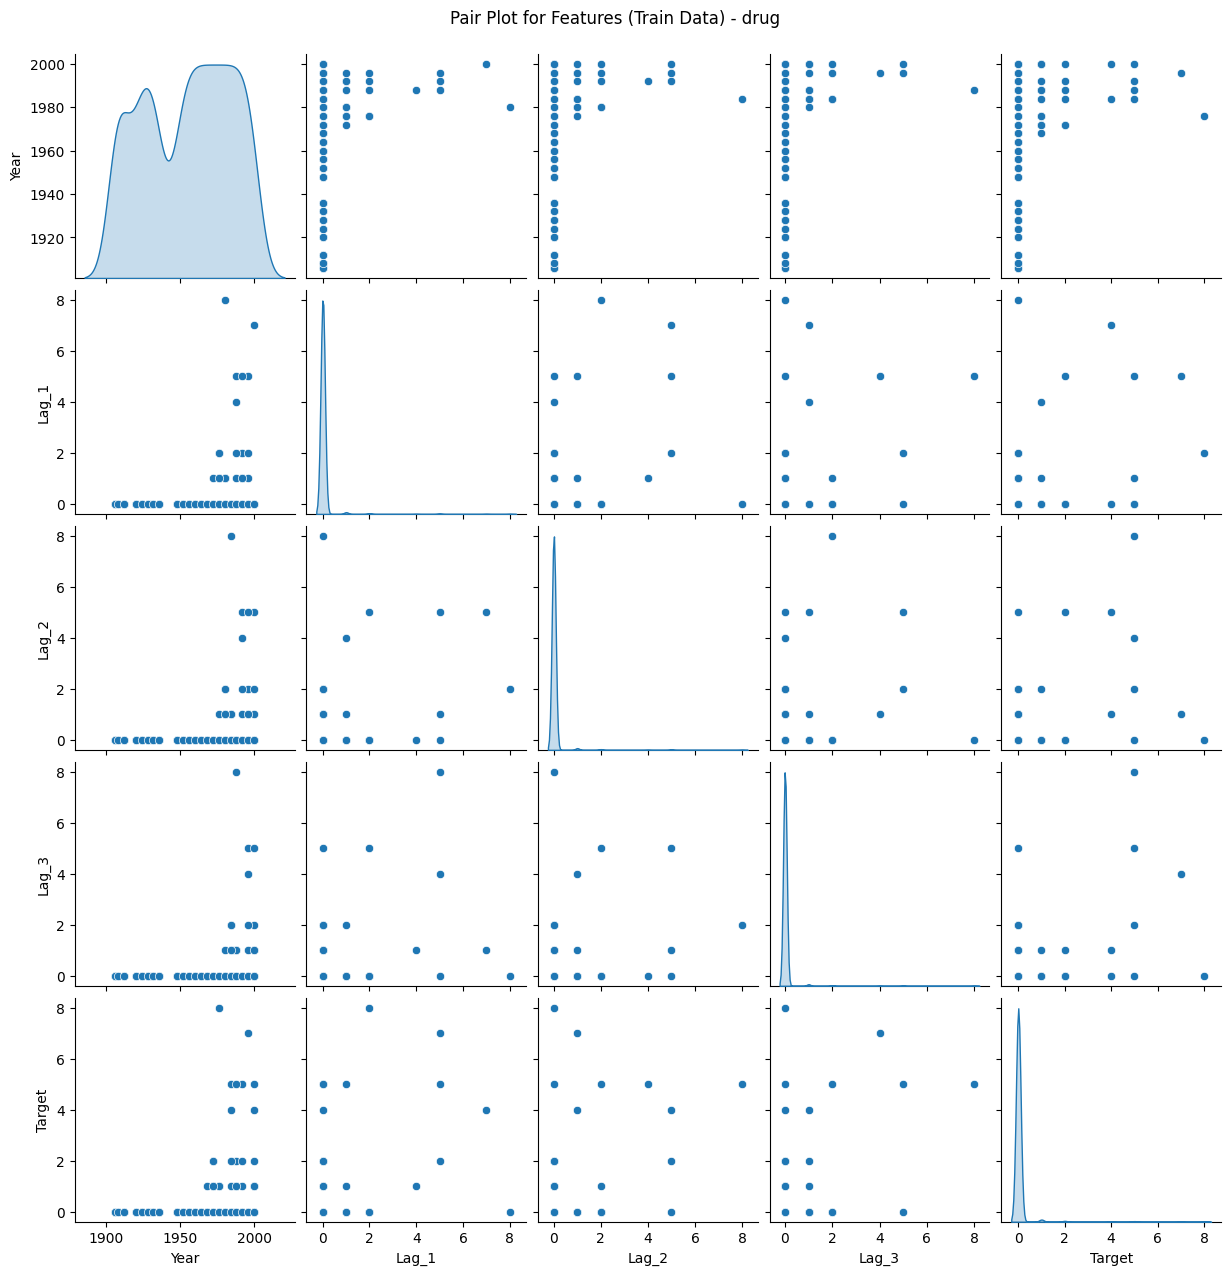

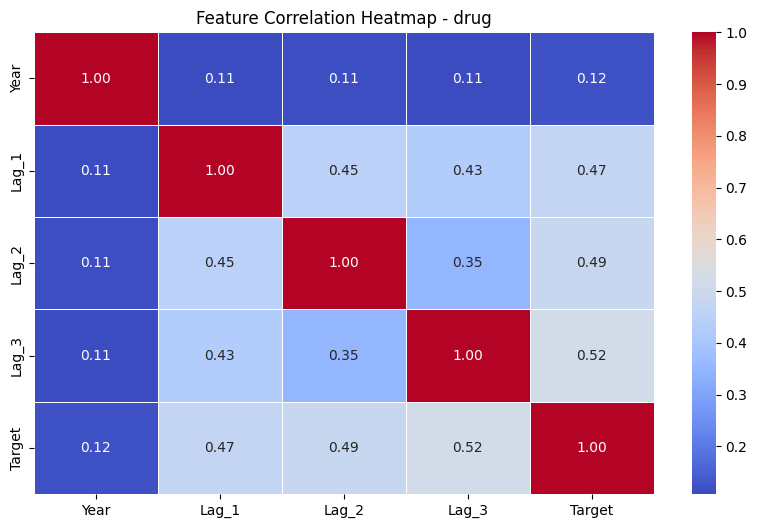

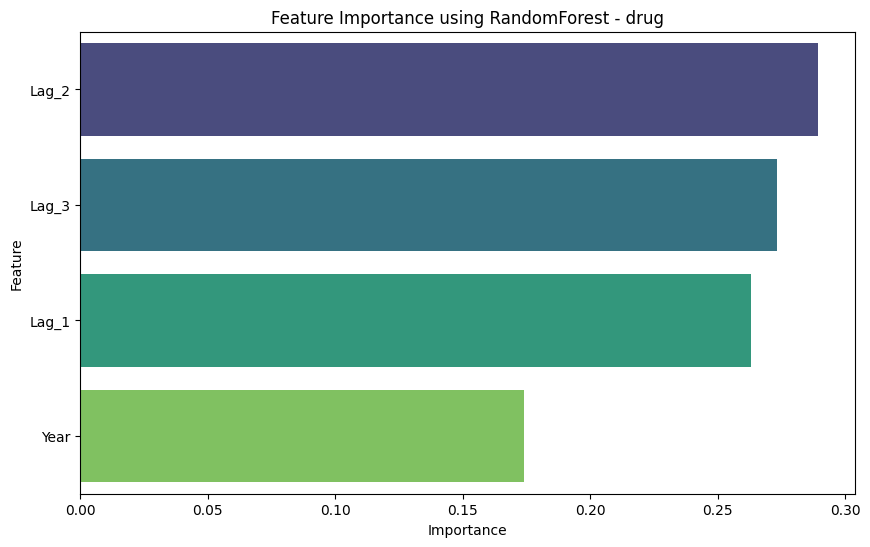

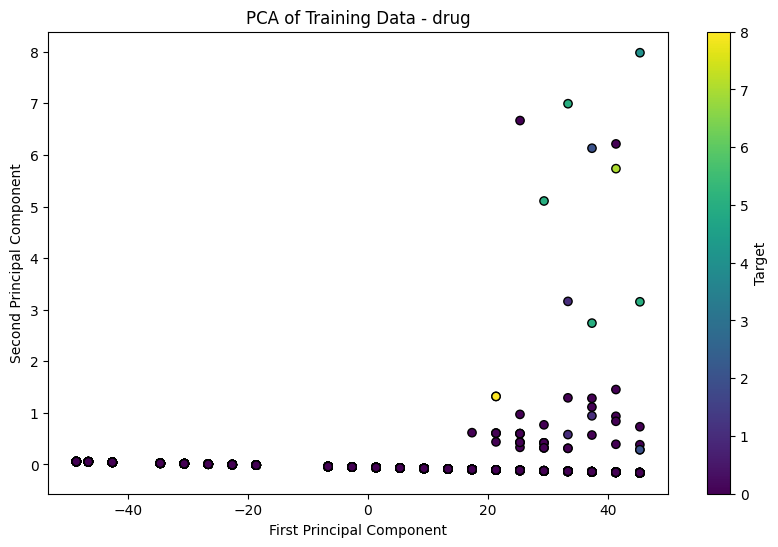


Stationarity Test and Rolling Statistics for Target Variable:
Results of Dickey-Fuller Test:
Test Statistic: -9.853513940864314
p-value: 4.421208746378689e-17
Critical Values:
   1%: -3.43476120520139
   5%: -2.863488262178673
   10%: -2.567807233388883


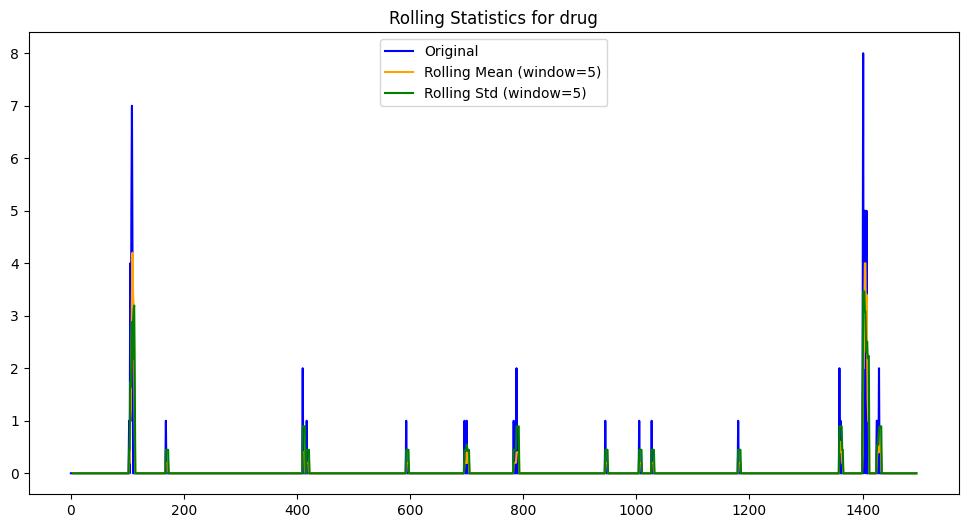


Autocorrelation and Partial Autocorrelation for Target Variable:


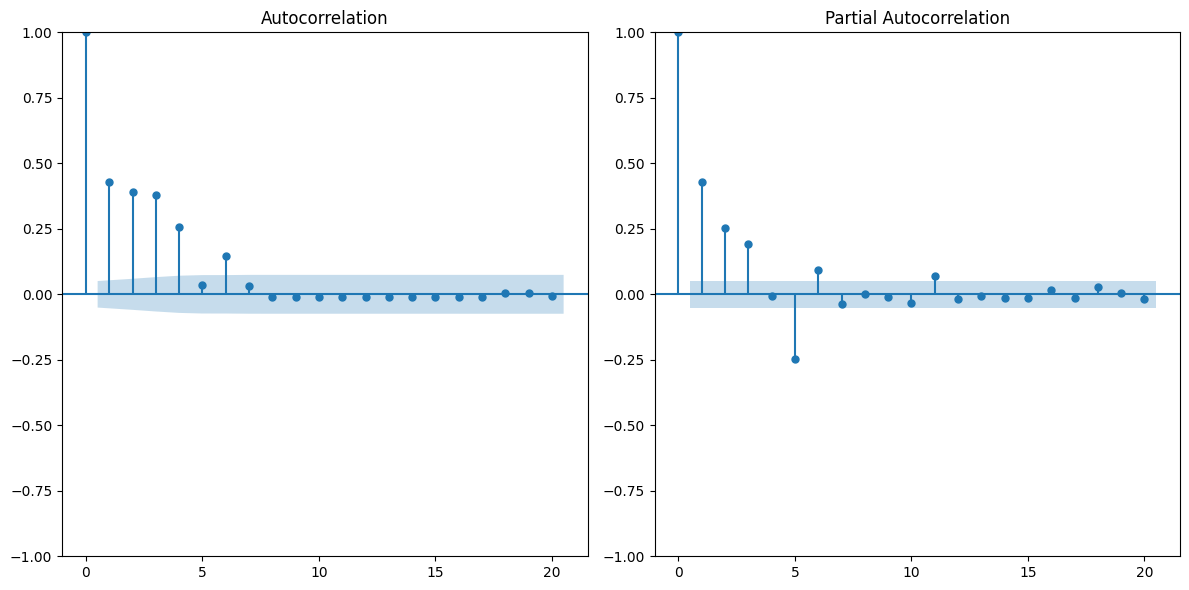


Training CatBoost...
CatBoost - Best Params: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05}
CatBoost - MSE: 29.141628881654682, R2: 0.015046059610178464

Training Random Forest...
Random Forest - Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - MSE: 25.995481907730223, R2: 0.12138225212696607

Training Decision Tree...
Decision Tree - Best Params: {'max_depth': 5, 'min_samples_split': 2}
Decision Tree - MSE: 29.921575877177645, R2: -0.011315262526455871

Training k-NN Regression...
k-NN Regression - Best Params: {'n_neighbors': 5, 'weights': 'uniform'}
k-NN Regression - MSE: 26.74019607843137, R2: 0.09621175943161786

Training XGBoost...
XGBoost - Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
XGBoost - MSE: 29.849957837722425, R2: -0.008894654177798333

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true

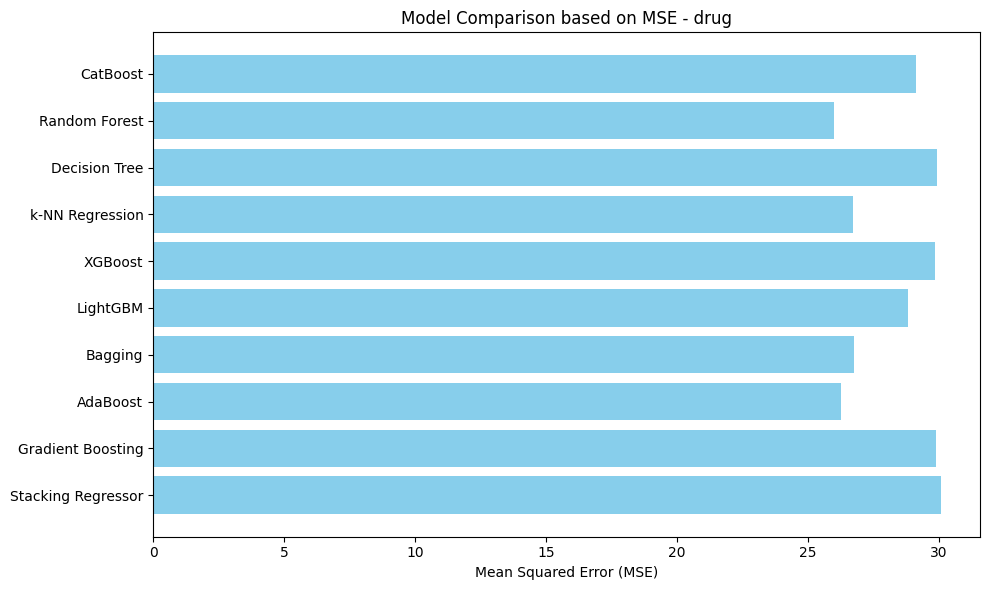

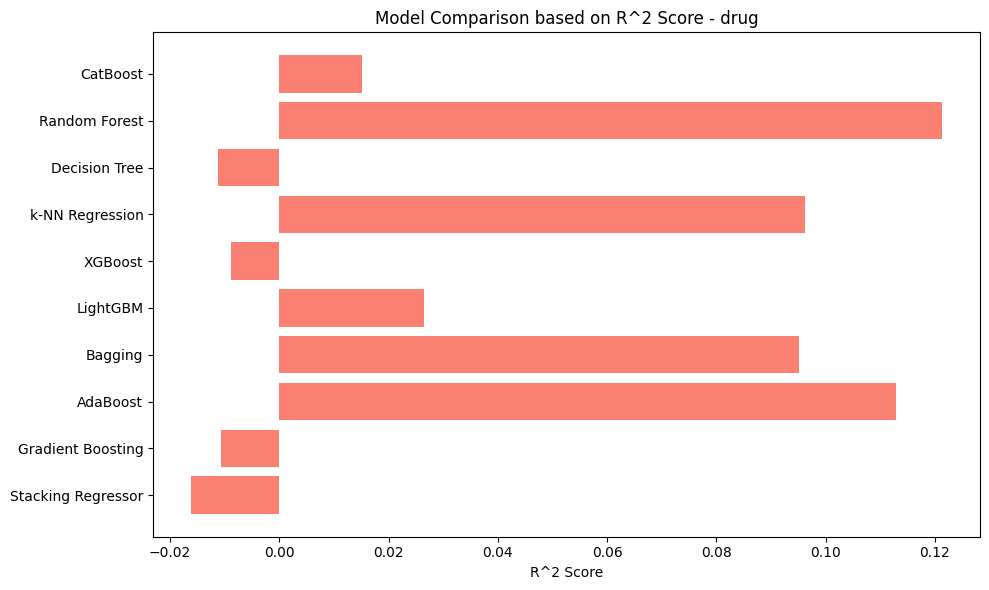


Best model for 'drug' is: Random Forest
Sport with the most non-zero 'drug' values: Athletics
Final selected sport for 'drug': Athletics

Processing parameter: equity

Data after cleaning and before modeling:
   index          Sport  Year    Target     Lag_1     Lag_2     Lag_3
0      0  Alpine Skiing  1956  0.357320  0.335979  0.258333  0.359223
1      0  Alpine Skiing  1960  0.403125  0.357320  0.335979  0.258333
2      0  Alpine Skiing  1964  0.328467  0.403125  0.357320  0.335979
3      0  Alpine Skiing  1968  0.319905  0.328467  0.403125  0.357320
4      0  Alpine Skiing  1972  0.384615  0.319905  0.328467  0.403125

Data before 2004: (519, 7)
Data from 2004 onwards: (182, 7)

Training Data - Descriptive Statistics
              Year       Lag_1       Lag_2       Lag_3
count   519.000000  519.000000  519.000000  519.000000
mean   1962.554913    0.141461    0.128550    0.115535
std      26.503594    0.194111    0.189074    0.184351
min    1906.000000    0.000000    0.000000    0.0

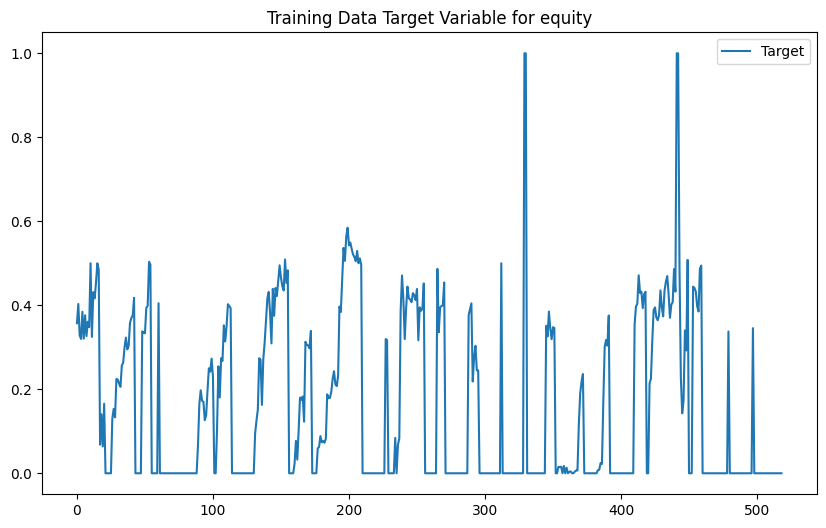


Test Data - Descriptive Statistics
              Year       Lag_1       Lag_2       Lag_3
count   182.000000  182.000000  182.000000  182.000000
mean   2013.934066    0.455022    0.431324    0.408753
std       6.737054    0.173828    0.189967    0.205644
min    2004.000000    0.000000    0.000000    0.000000
25%    2008.000000    0.385367    0.366358    0.341992
50%    2012.000000    0.485812    0.453442    0.426085
75%    2020.000000    0.500000    0.500000    0.498471
max    2024.000000    1.000000    1.000000    1.000000

Test Data Target Variable - Descriptive Statistics
count    182.000000
mean       0.473120
std        0.164031
min        0.000000
25%        0.403977
50%        0.500000
75%        0.500000
max        1.000000
Name: Target, dtype: float64


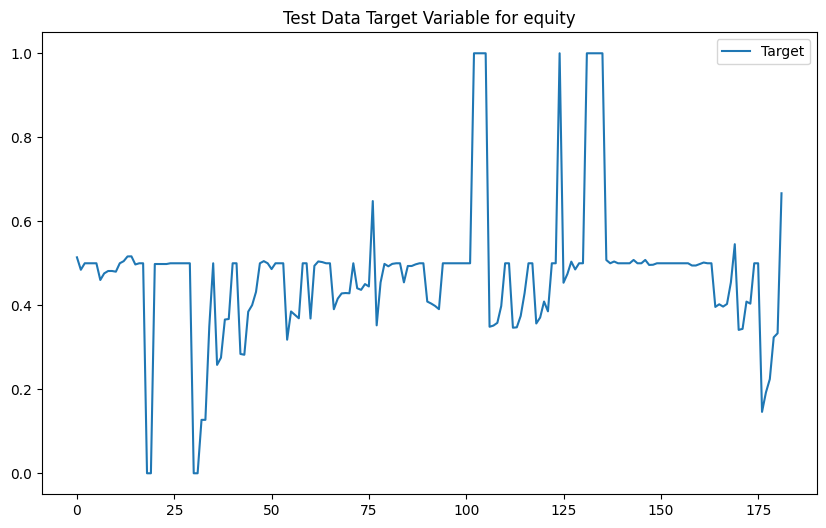

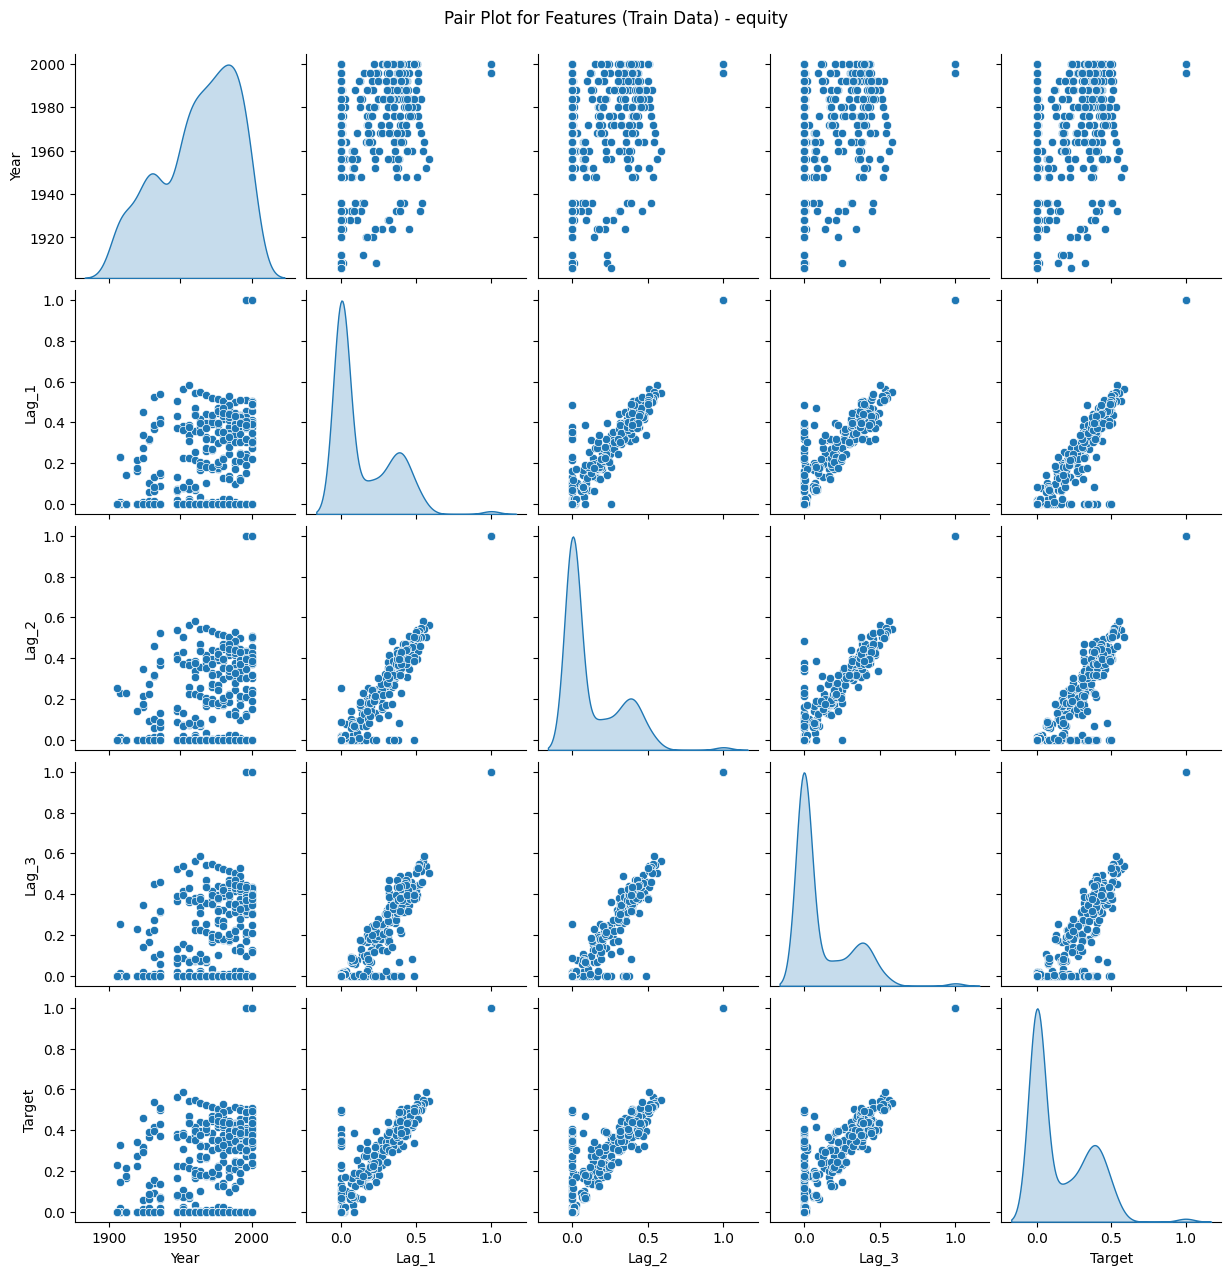

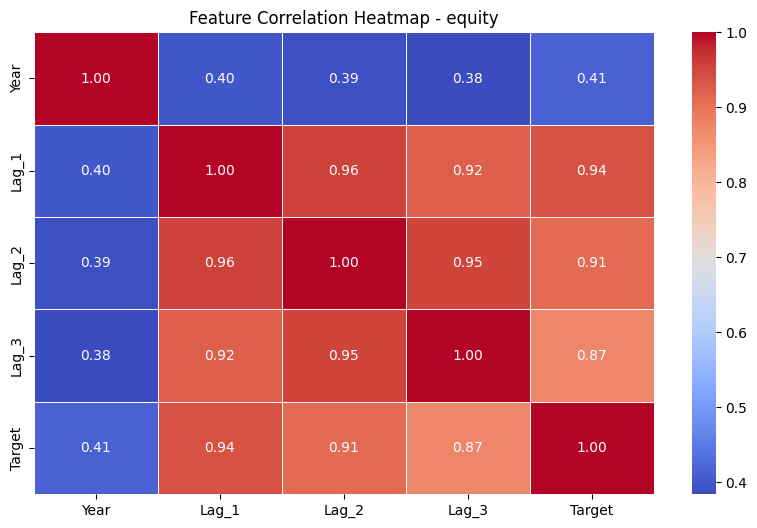

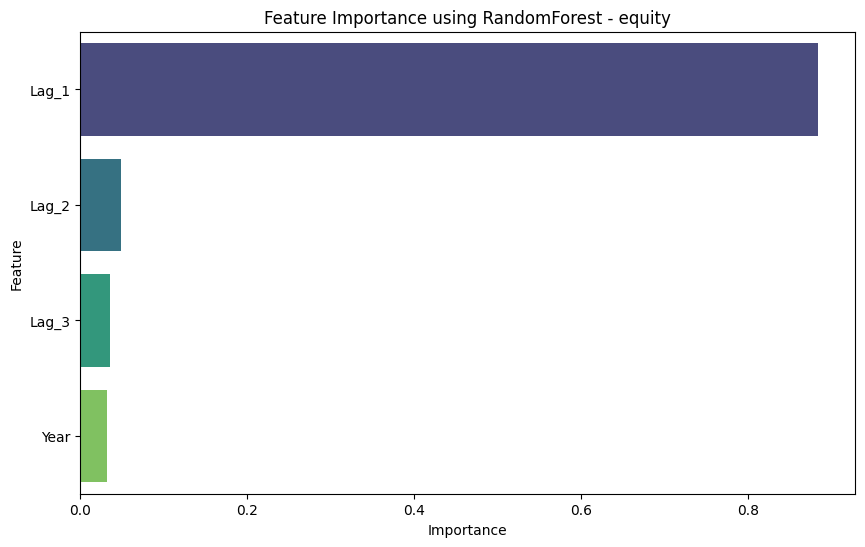

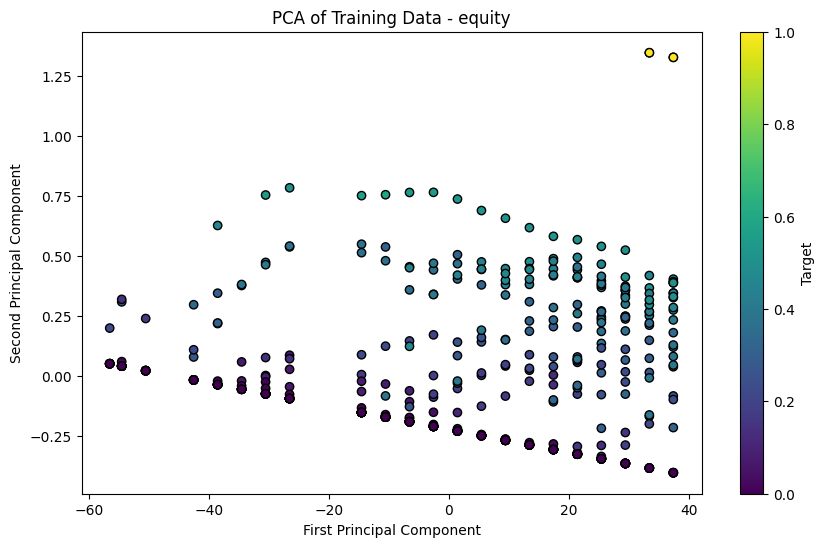


Stationarity Test and Rolling Statistics for Target Variable:
Results of Dickey-Fuller Test:
Test Statistic: -7.96006049157495
p-value: 2.9650807182162095e-12
Critical Values:
   1%: -3.443037261465839
   5%: -2.8671357972350493
   10%: -2.569750352856994


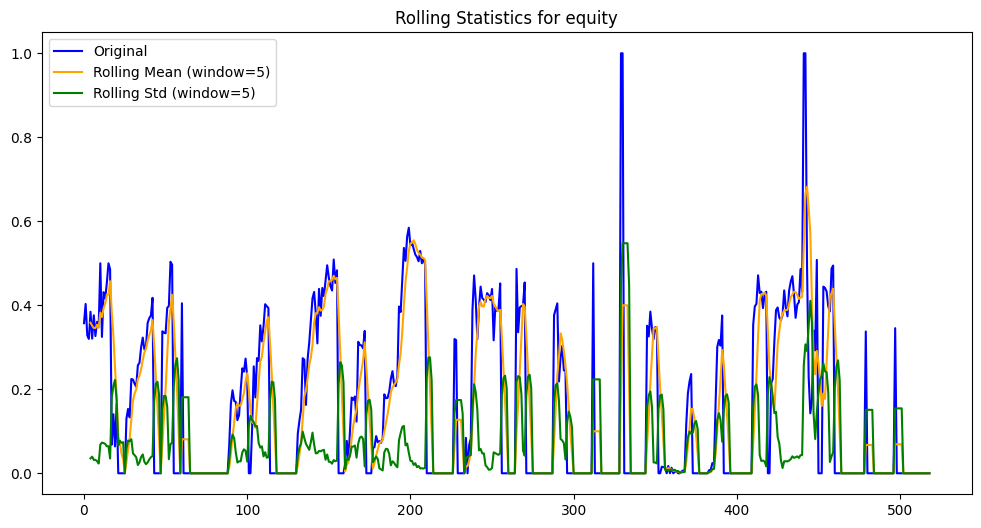


Autocorrelation and Partial Autocorrelation for Target Variable:


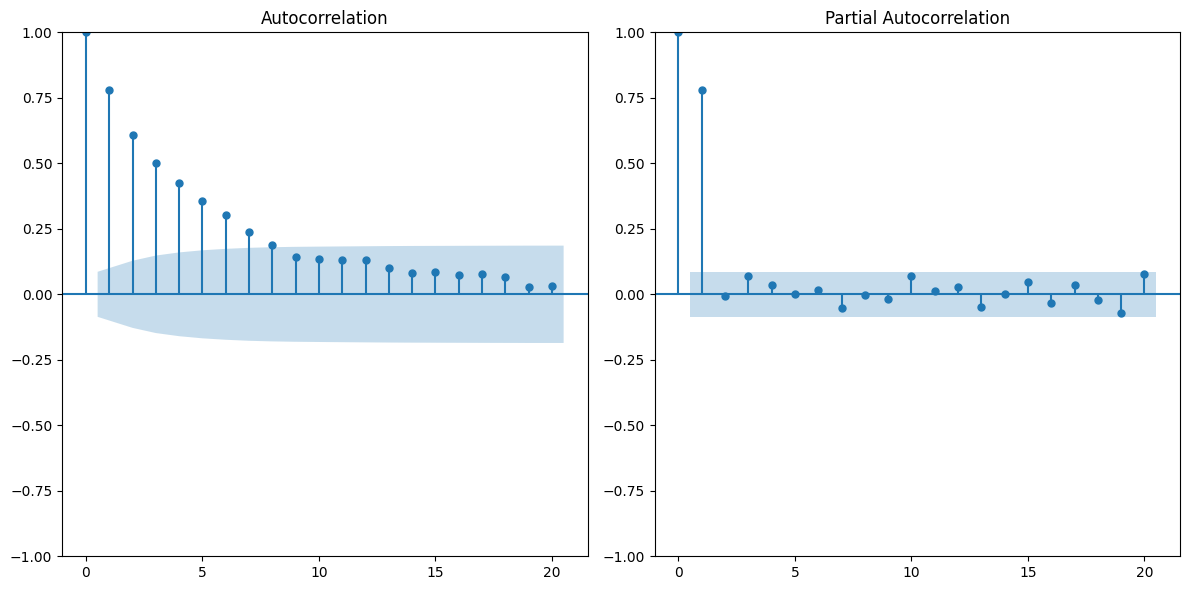


Training CatBoost...
CatBoost - Best Params: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05}
CatBoost - MSE: 0.003693199828884887, R2: 0.8619792577399836

Training Random Forest...
Random Forest - Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - MSE: 0.003576716646975624, R2: 0.8663324192185975

Training Decision Tree...
Decision Tree - Best Params: {'max_depth': 5, 'min_samples_split': 5}
Decision Tree - MSE: 0.003704388264638523, R2: 0.8615611281290788

Training k-NN Regression...
k-NN Regression - Best Params: {'n_neighbors': 3, 'weights': 'distance'}
k-NN Regression - MSE: 0.005356227848969781, R2: 0.7998292598069915

Training XGBoost...
XGBoost - Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
XGBoost - MSE: 0.003296463452577717, R2: 0.8768059261241848

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=tr

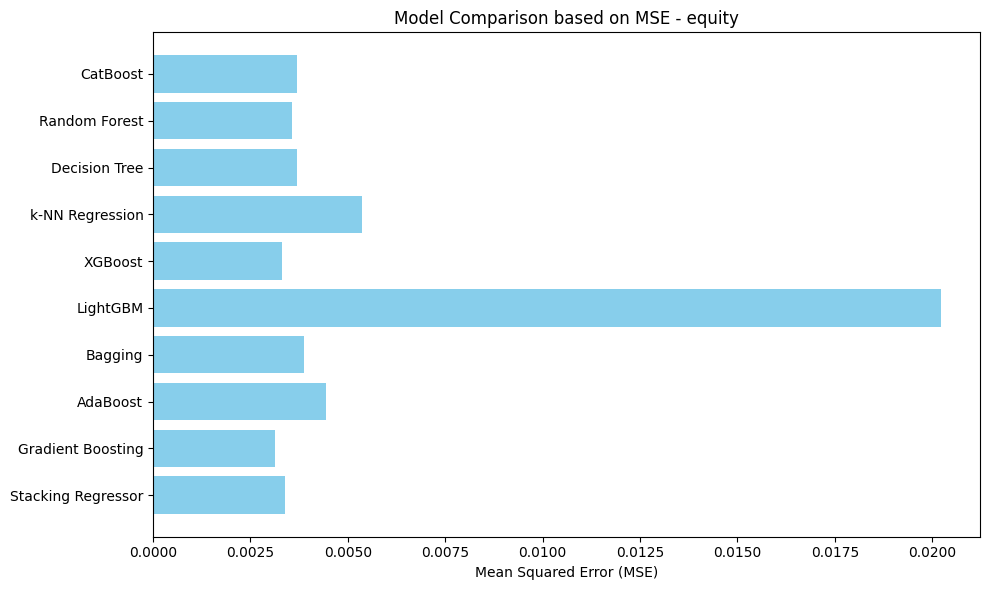

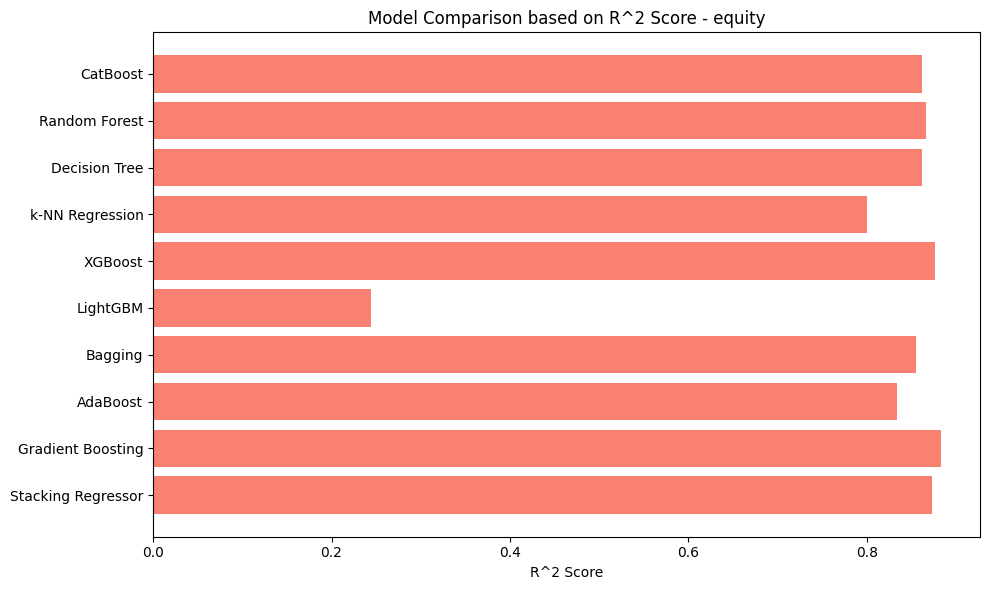


Best model for 'equity' is: Gradient Boosting
Sport with the most non-zero 'equity' values: Diving
Final selected sport for 'equity': Diving

Processing parameter: popularity

Data after cleaning and before modeling:
   index          Sport  Year  Target  Lag_1  Lag_2  Lag_3
0      0  Alpine Skiing  1906     0.0    0.0    0.0    0.0
1      0  Alpine Skiing  1908     0.0    0.0    0.0    0.0
2      0  Alpine Skiing  1912     0.0    0.0    0.0    0.0
3      0  Alpine Skiing  1920     0.0    0.0    0.0    0.0
4      0  Alpine Skiing  1924     0.0    0.0    0.0    0.0

Data before 2004: (1430, 7)
Data from 2004 onwards: (390, 7)

Training Data - Descriptive Statistics
              Year        Lag_1        Lag_2        Lag_3
count  1430.000000  1430.000000  1430.000000  1430.000000
mean   1954.636364     0.015385     0.015385     0.015385
std      29.363208     0.033322     0.033584     0.035045
min    1906.000000     0.000000     0.000000     0.000000
25%    1928.000000     0.000000     

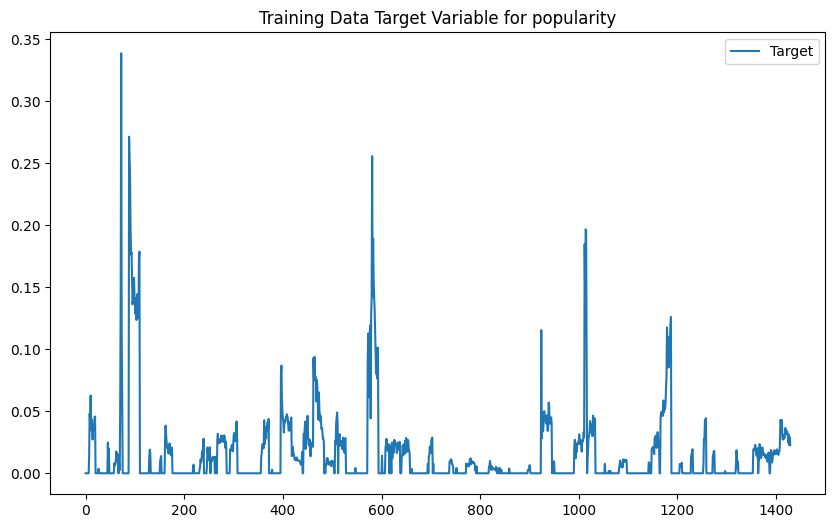


Test Data - Descriptive Statistics
              Year       Lag_1       Lag_2       Lag_3
count   390.000000  390.000000  390.000000  390.000000
mean   2014.000000    0.015385    0.015385    0.015385
std       6.840075    0.028060    0.028479    0.027621
min    2004.000000    0.000000    0.000000    0.000000
25%    2008.000000    0.000000    0.000000    0.000000
50%    2014.000000    0.002429    0.002367    0.005259
75%    2020.000000    0.021720    0.021283    0.021283
max    2024.000000    0.183226    0.183226    0.178569

Test Data Target Variable - Descriptive Statistics
count    390.000000
mean       0.015385
std        0.027673
min        0.000000
25%        0.000000
50%        0.002345
75%        0.022194
max        0.183226
Name: Target, dtype: float64


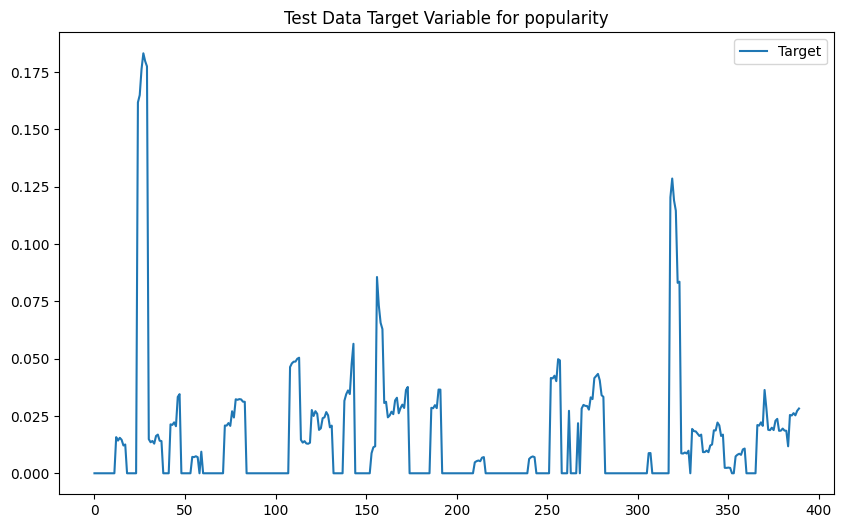

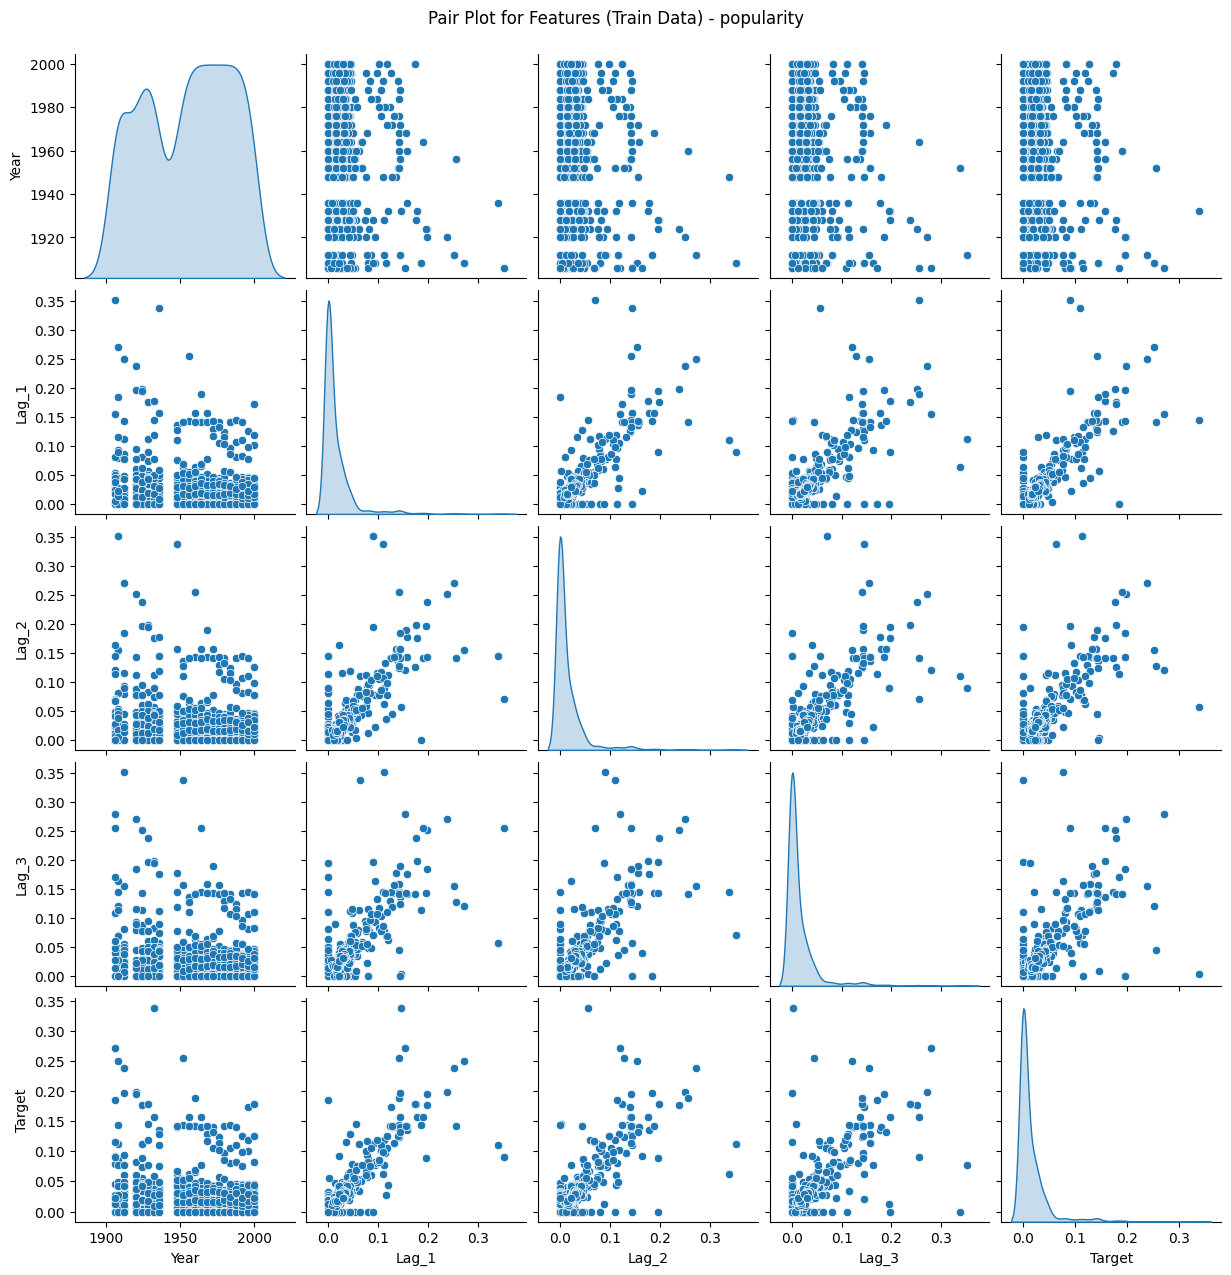

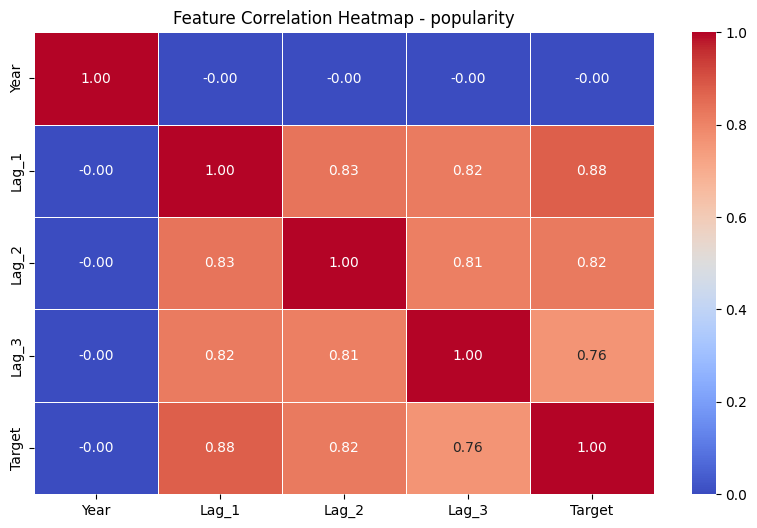

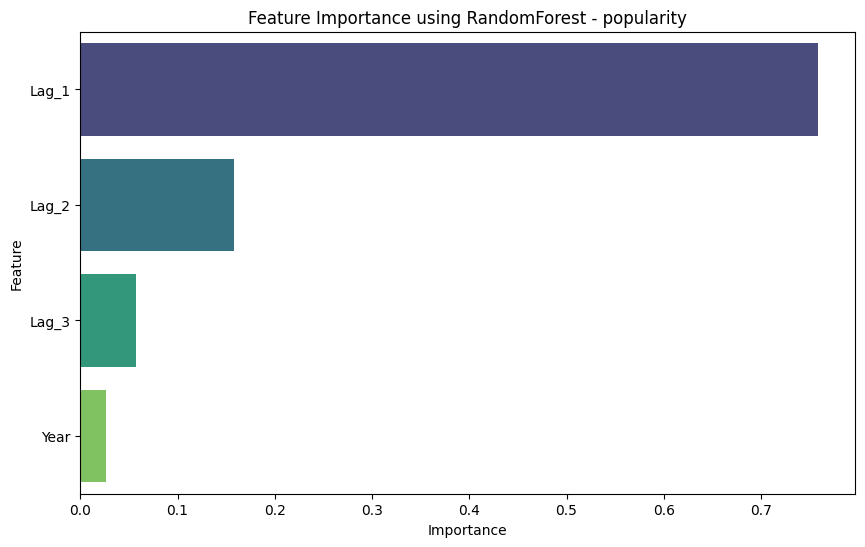

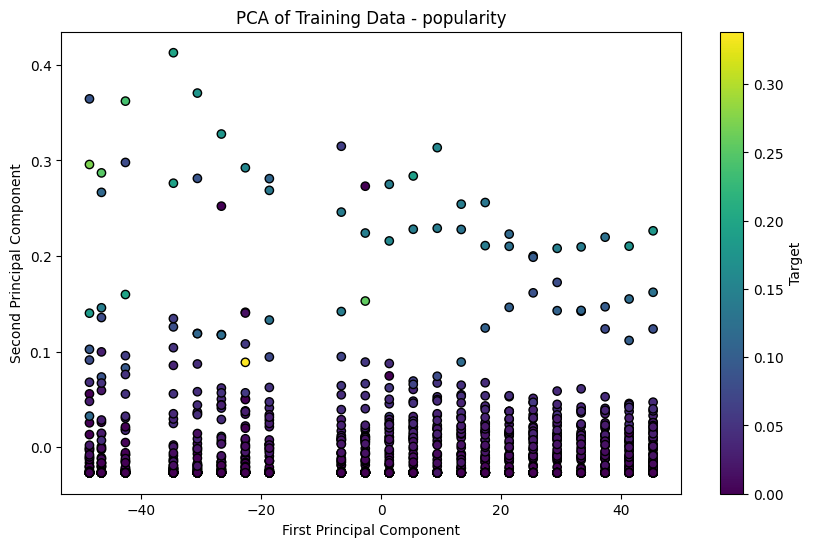


Stationarity Test and Rolling Statistics for Target Variable:
Results of Dickey-Fuller Test:
Test Statistic: -6.580371379743291
p-value: 7.540727090703425e-09
Critical Values:
   1%: -3.4350061979197215
   5%: -2.863596381993834
   10%: -2.5678648091303056


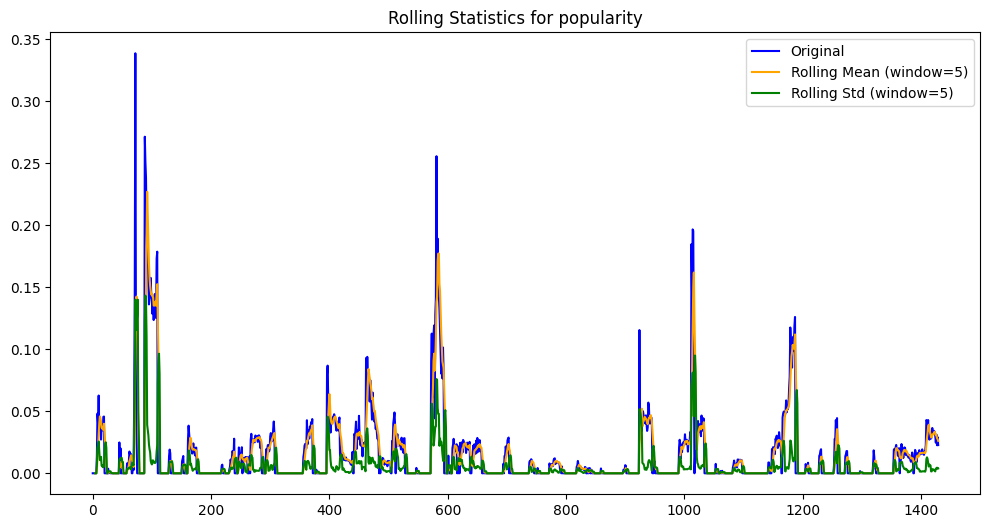


Autocorrelation and Partial Autocorrelation for Target Variable:


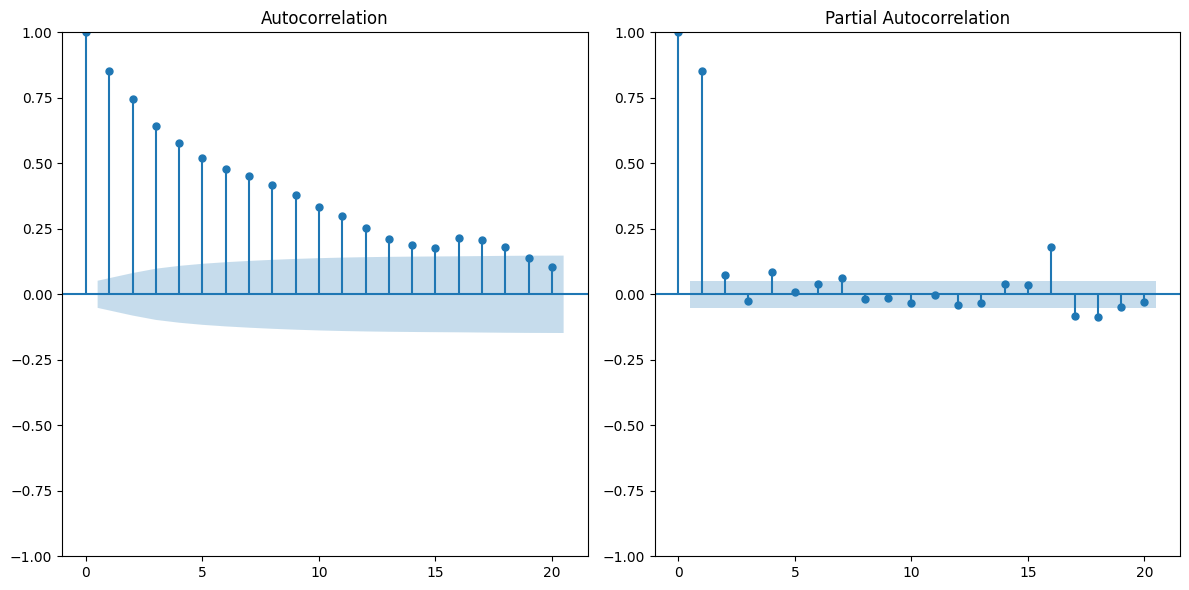


Training CatBoost...
CatBoost - Best Params: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05}
CatBoost - MSE: 4.0980557104197156e-05, R2: 0.9463475497686898

Training Random Forest...
Random Forest - Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - MSE: 4.015177494950444e-05, R2: 0.947432605620766

Training Decision Tree...
Decision Tree - Best Params: {'max_depth': 5, 'min_samples_split': 5}
Decision Tree - MSE: 5.7670036083000596e-05, R2: 0.9244973968286011

Training k-NN Regression...
k-NN Regression - Best Params: {'n_neighbors': 3, 'weights': 'distance'}
k-NN Regression - MSE: 6.531809951958279e-05, R2: 0.9144844206298197

Training XGBoost...
XGBoost - Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
XGBoost - MSE: 3.4499735092829715e-05, R2: 0.9548323534168877

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_

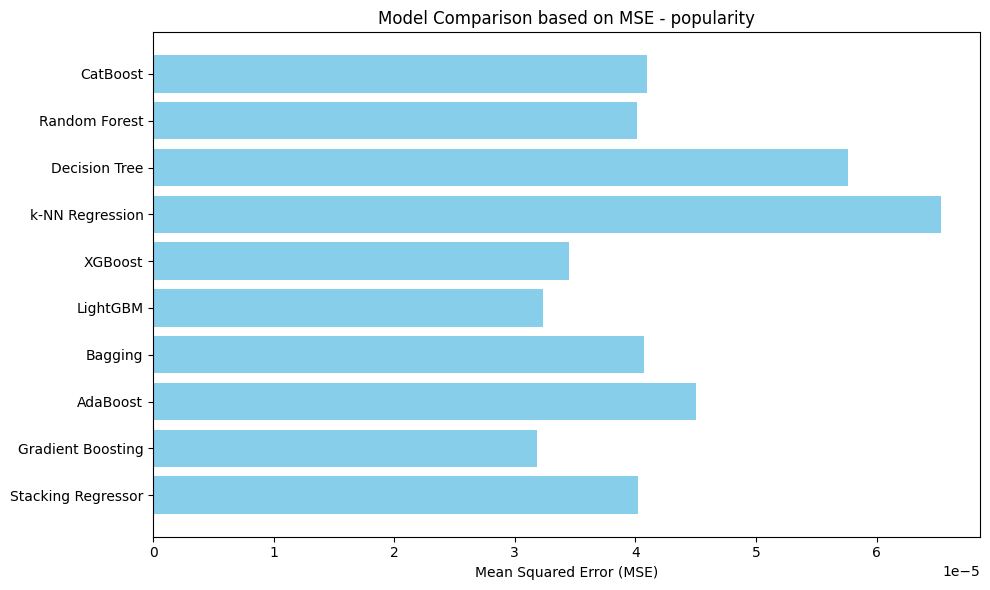

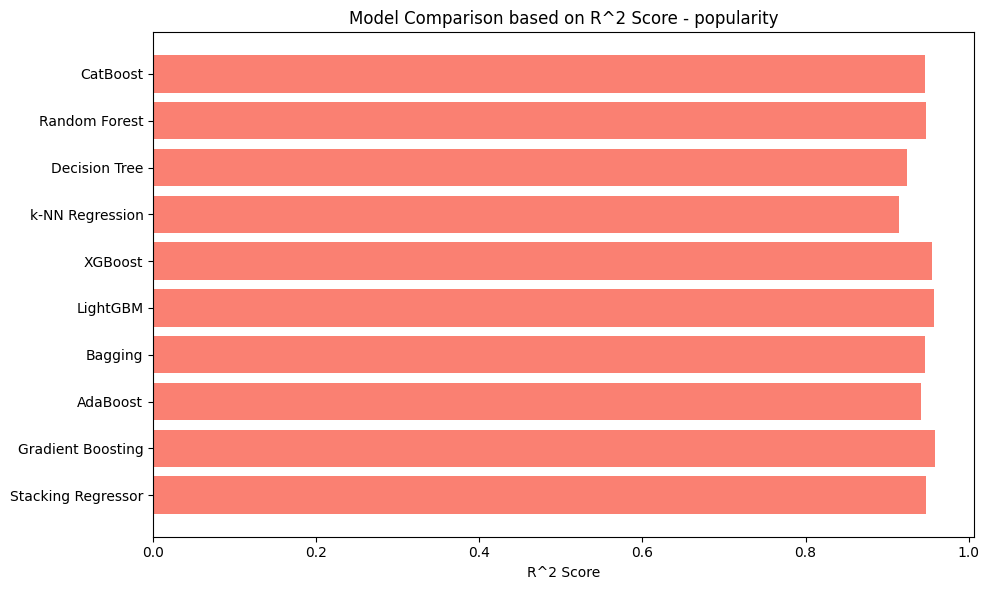


Best model for 'popularity' is: Gradient Boosting
Sport with the most non-zero 'popularity' values: Athletics
Final selected sport for 'popularity': Athletics

Processing parameter: normalizedcountry

Data after cleaning and before modeling:
   index          Sport  Year  Target  Lag_1  Lag_2  Lag_3
0      0  Alpine Skiing  1956   0.145  0.140  0.125  0.130
1      0  Alpine Skiing  1960   0.110  0.145  0.140  0.125
2      0  Alpine Skiing  1964   0.155  0.110  0.145  0.140
3      0  Alpine Skiing  1968   0.165  0.155  0.110  0.145
4      0  Alpine Skiing  1972   0.135  0.165  0.155  0.110

Data before 2004: (519, 7)
Data from 2004 onwards: (124, 7)

Training Data - Descriptive Statistics
              Year       Lag_1       Lag_2       Lag_3
count   519.000000  519.000000  519.000000  519.000000
mean   1962.554913    0.136532    0.125636    0.115395
std      26.503594    0.112190    0.099606    0.090232
min    1906.000000    0.005000    0.005000    0.005000
25%    1948.000000    0.070

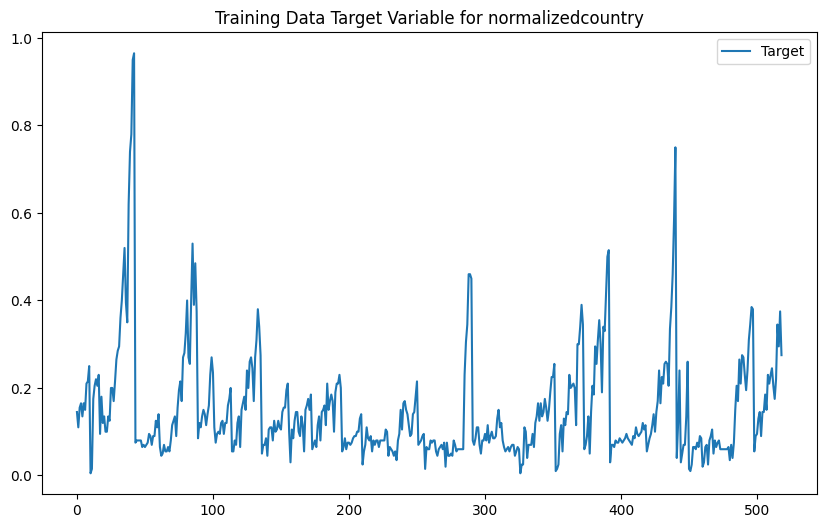


Test Data - Descriptive Statistics
              Year       Lag_1       Lag_2       Lag_3
count   124.000000  124.000000  124.000000  124.000000
mean   2010.161290    0.261653    0.255000    0.245484
std       4.458275    0.208894    0.201844    0.190183
min    2004.000000    0.040000    0.040000    0.040000
25%    2008.000000    0.113750    0.105000    0.105000
50%    2012.000000    0.217500    0.210000    0.210000
75%    2016.000000    0.311250    0.310000    0.311250
max    2016.000000    1.005000    1.000000    0.980000

Test Data Target Variable - Descriptive Statistics
count    124.000000
mean       0.270565
std        0.214783
min        0.040000
25%        0.115000
50%        0.227500
75%        0.330000
max        1.005000
Name: Target, dtype: float64


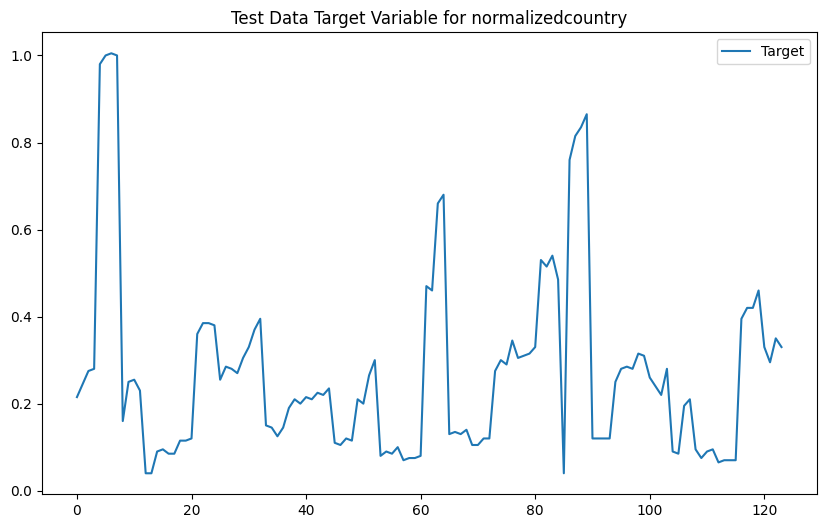

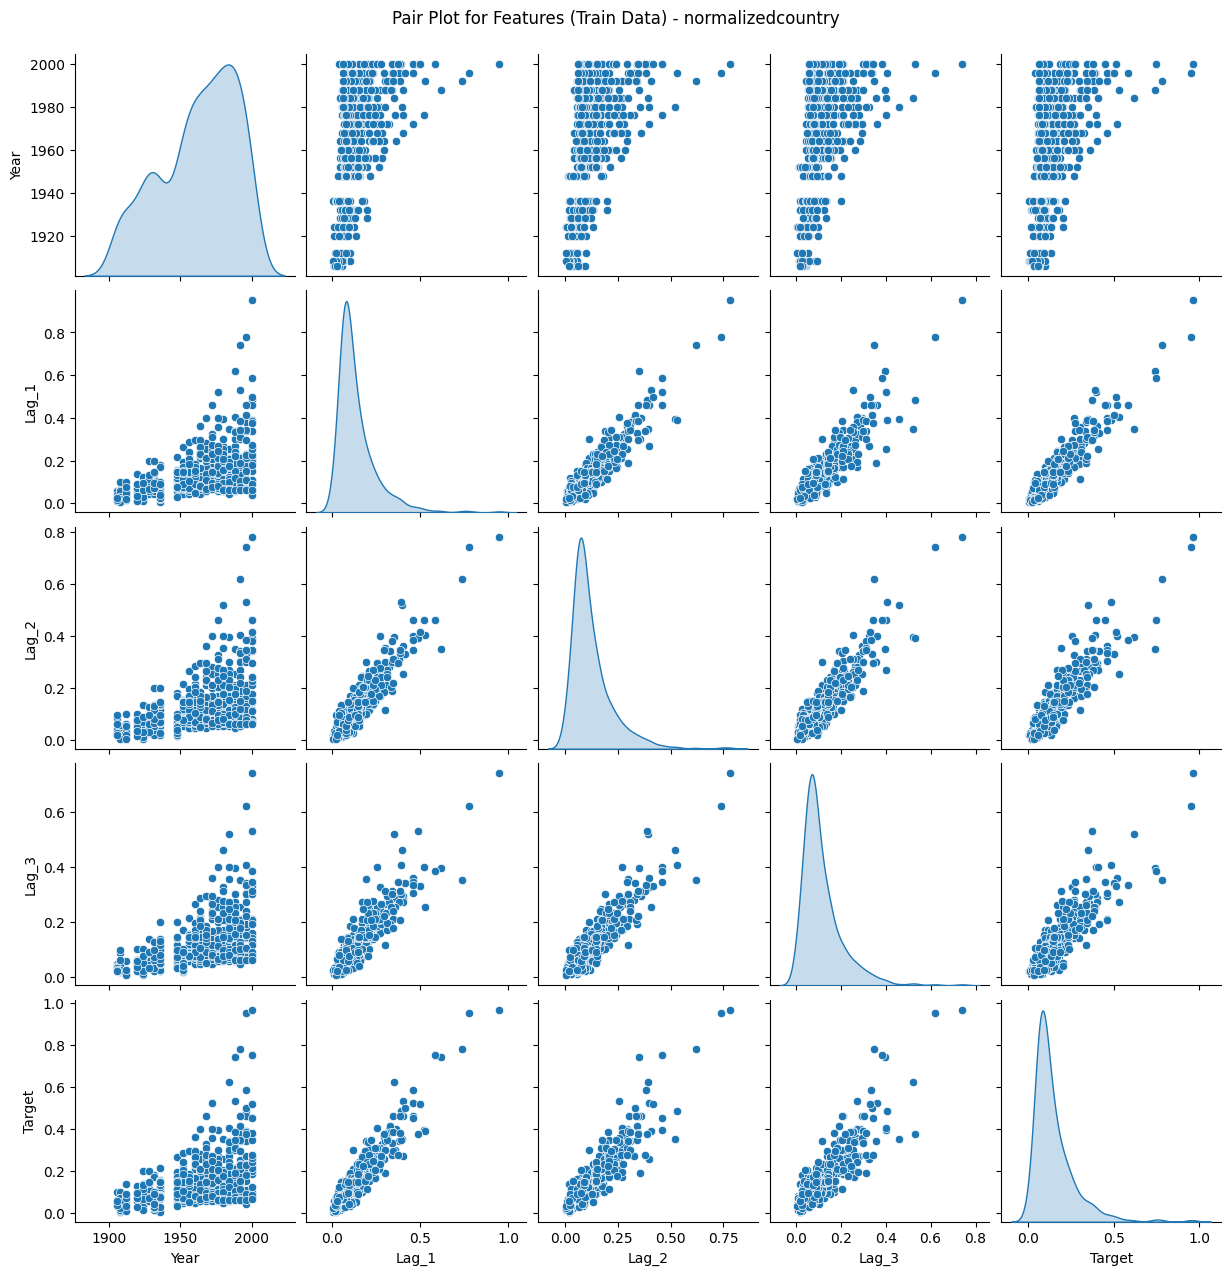

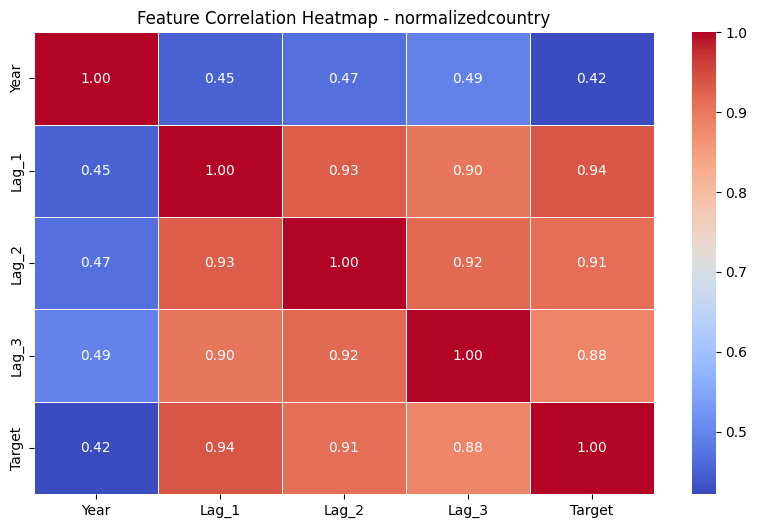

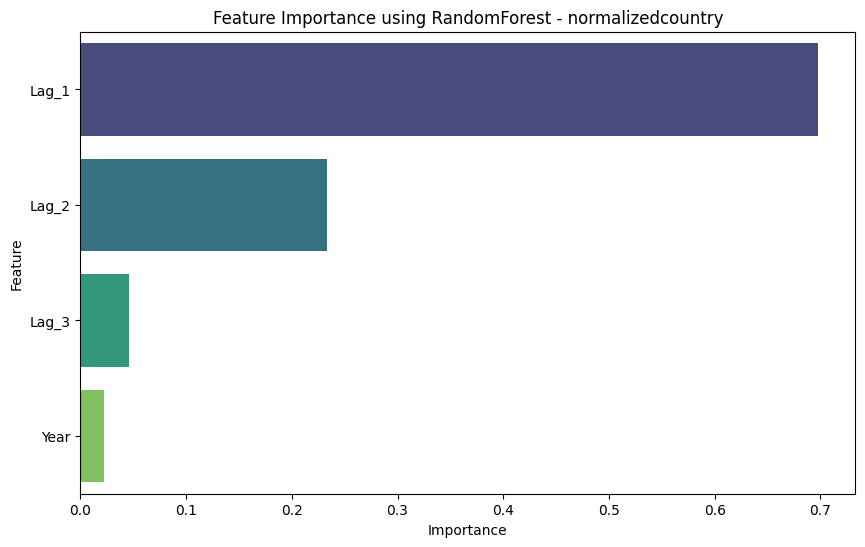

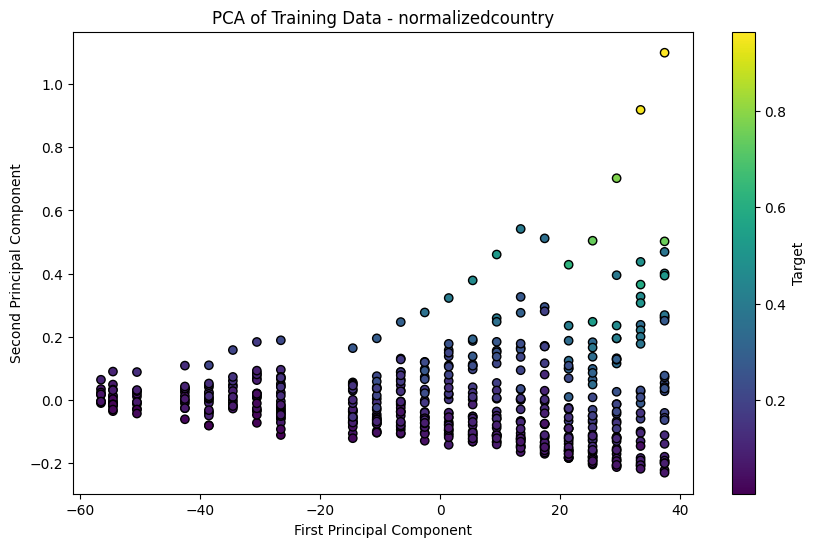


Stationarity Test and Rolling Statistics for Target Variable:
Results of Dickey-Fuller Test:
Test Statistic: -5.61614664512566
p-value: 1.173185448903407e-06
Critical Values:
   1%: -3.443186695642769
   5%: -2.86720156693697
   10%: -2.569785402984619


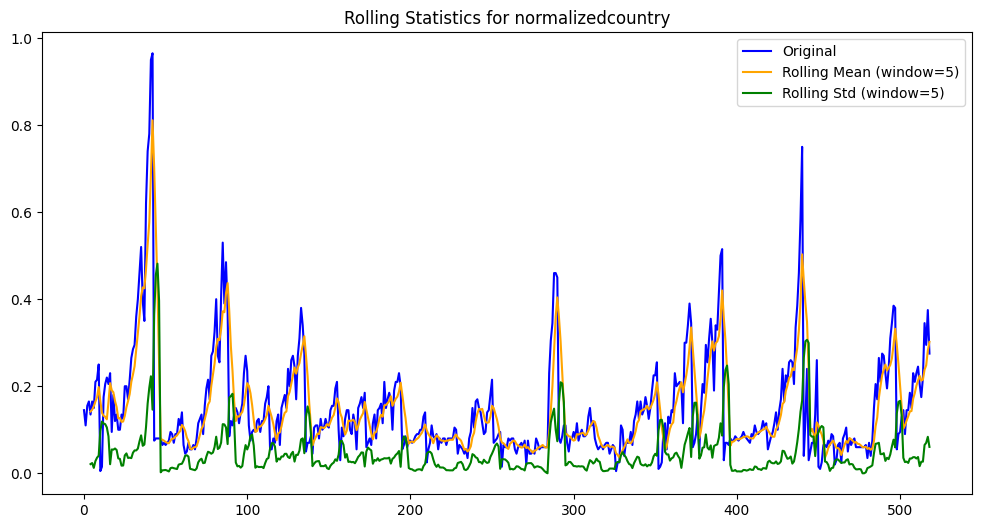


Autocorrelation and Partial Autocorrelation for Target Variable:


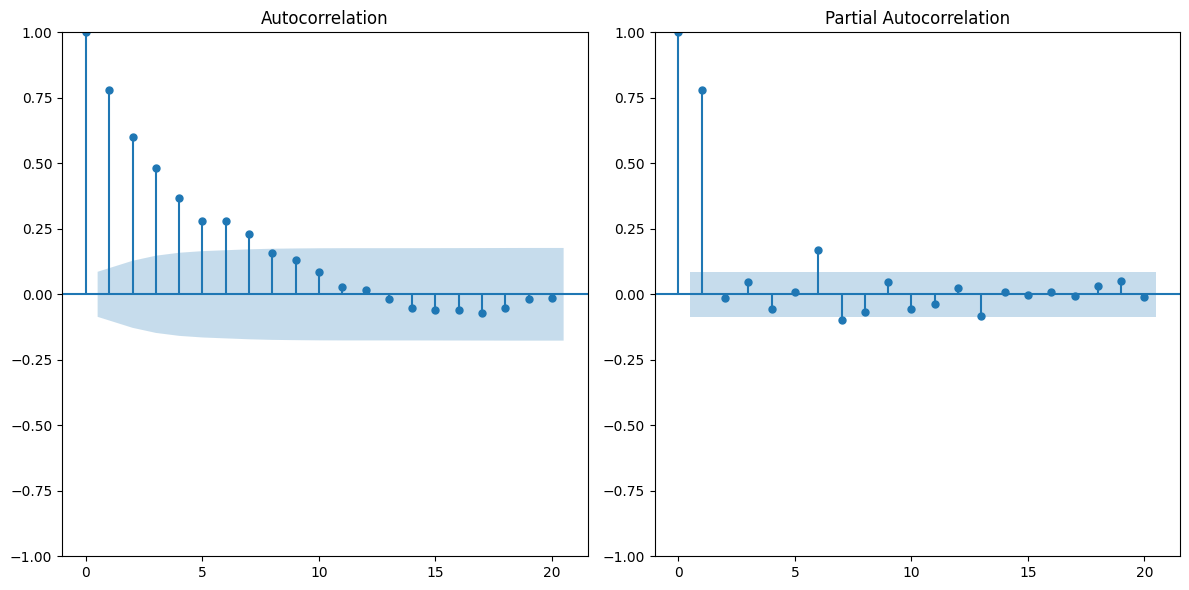


Training CatBoost...
CatBoost - Best Params: {'depth': 6, 'iterations': 100, 'learning_rate': 0.05}
CatBoost - MSE: 0.0016873475431870226, R2: 0.9631259545358895

Training Random Forest...
Random Forest - Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest - MSE: 0.0016888368369175617, R2: 0.9630934086119919

Training Decision Tree...
Decision Tree - Best Params: {'max_depth': 5, 'min_samples_split': 5}
Decision Tree - MSE: 0.0026520740265570516, R2: 0.9420435353556489

Training k-NN Regression...
k-NN Regression - Best Params: {'n_neighbors': 3, 'weights': 'distance'}
k-NN Regression - MSE: 0.0051767122046894294, R2: 0.8868719595076469

Training XGBoost...
XGBoost - Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
XGBoost - MSE: 0.0016062443634138682, R2: 0.9648983234531966

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_

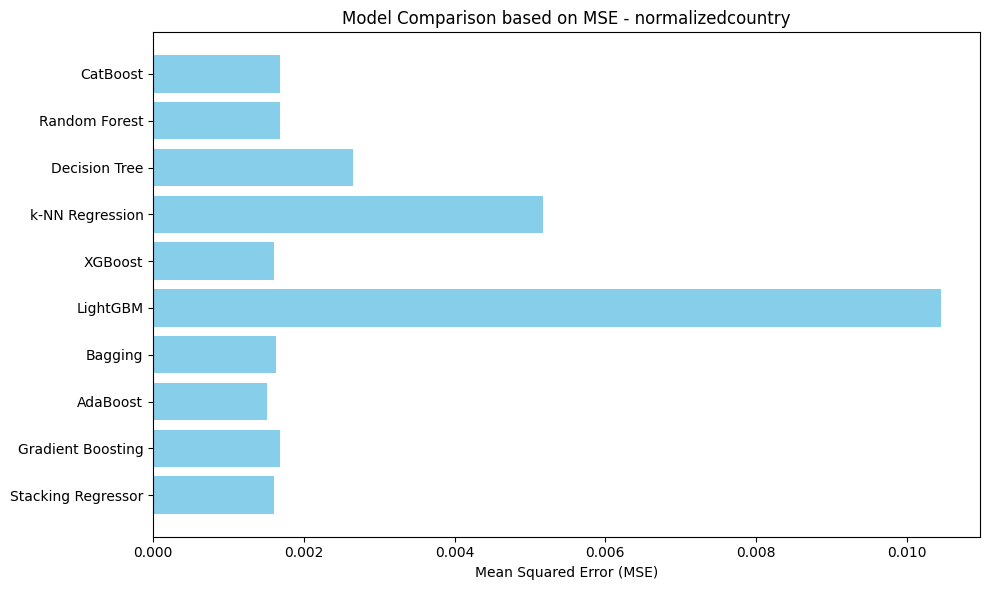

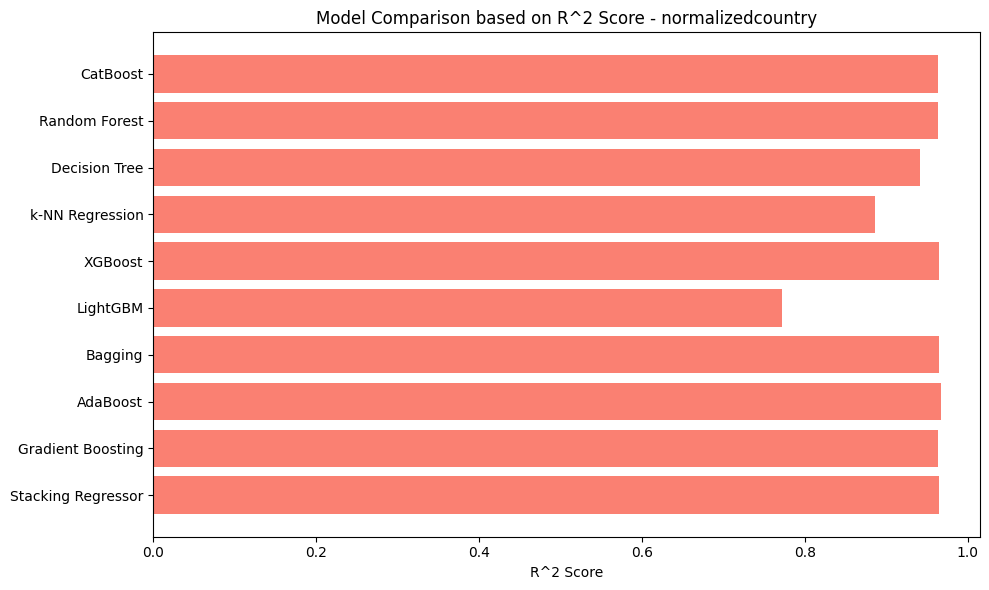


Best model for 'normalizedcountry' is: AdaBoost
Sport with the most non-zero 'normalizedcountry' values: Athletics
Final selected sport for 'normalizedcountry': Athletics

Processing parameter: CV

Data after cleaning and before modeling:
   index          Sport  Year  Target  Lag_1  Lag_2  Lag_3
0      0  Alpine Skiing  1906     0.0    0.0    0.0    0.0
1      0  Alpine Skiing  1908     0.0    0.0    0.0    0.0
2      0  Alpine Skiing  1912     0.0    0.0    0.0    0.0
3      0  Alpine Skiing  1920     0.0    0.0    0.0    0.0
4      0  Alpine Skiing  1924     0.0    0.0    0.0    0.0

Data before 2000: (1428, 7)
Data from 2000 onwards: (340, 7)

Training Data - Descriptive Statistics
              Year        Lag_1        Lag_2        Lag_3
count  1428.000000  1428.000000  1428.000000  1428.000000
mean   1952.476190     0.326198     0.314469     0.298595
std      28.293538     0.401606     0.399593     0.397772
min    1906.000000     0.000000     0.000000     0.000000
25%    1928.00

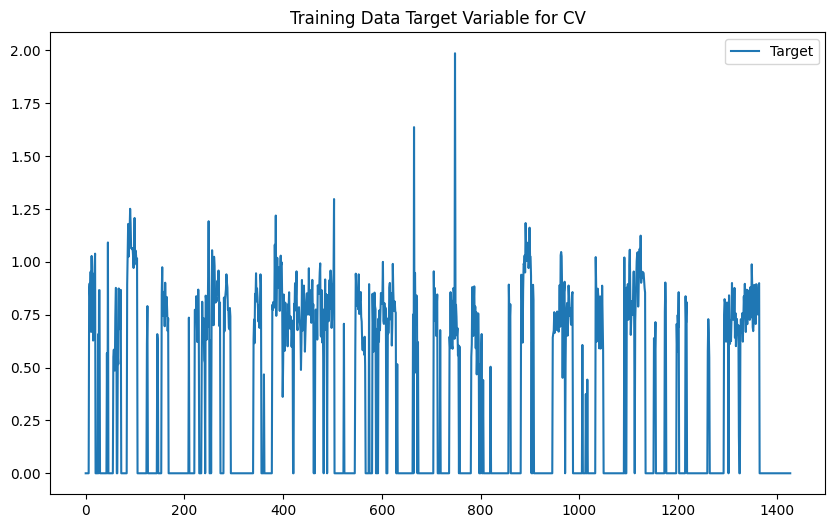


Test Data - Descriptive Statistics
              Year       Lag_1       Lag_2       Lag_3
count   340.000000  340.000000  340.000000  340.000000
mean   2008.000000    0.373511    0.395223    0.407358
std       5.665192    0.396331    0.398472    0.403864
min    2000.000000    0.000000    0.000000    0.000000
25%    2004.000000    0.000000    0.000000    0.000000
50%    2008.000000    0.000000    0.554573    0.562092
75%    2012.000000    0.749029    0.757190    0.773773
max    2016.000000    1.296968    1.296968    1.296968

Test Data Target Variable - Descriptive Statistics
count    340.000000
mean       0.375813
std        0.391693
min        0.000000
25%        0.000000
50%        0.000000
75%        0.740587
max        1.252190
Name: Target, dtype: float64


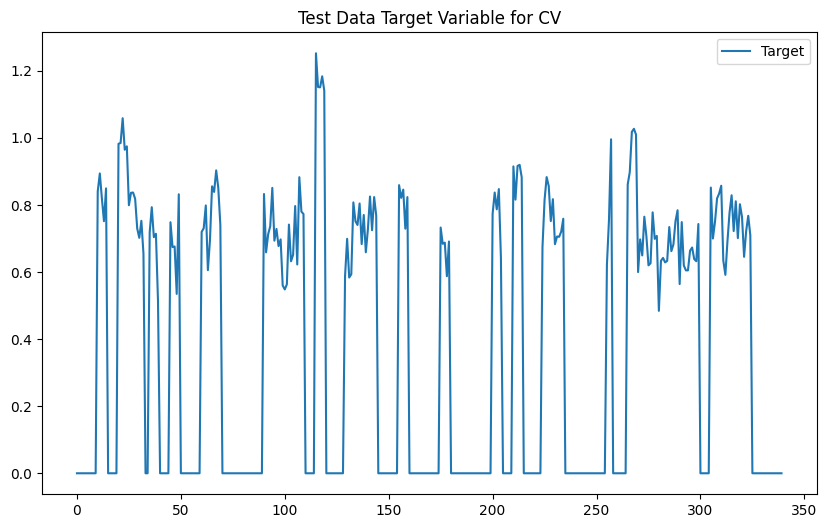

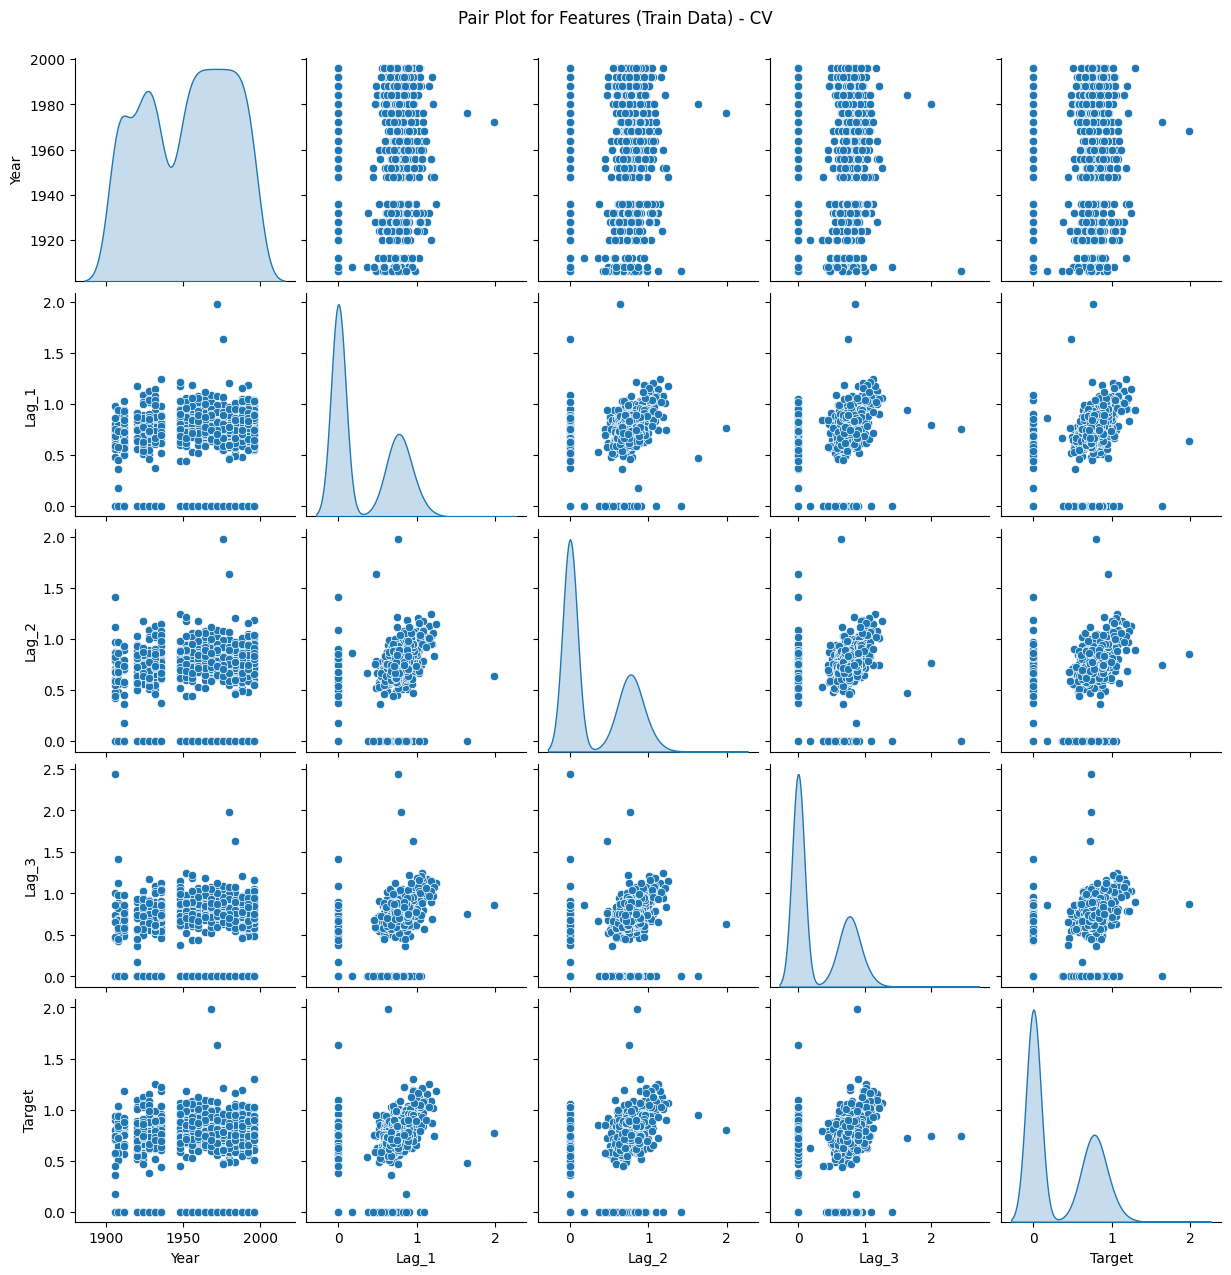

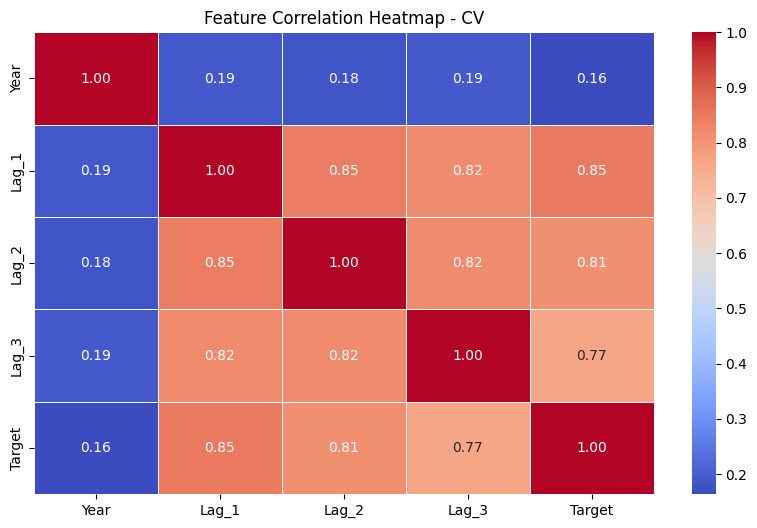

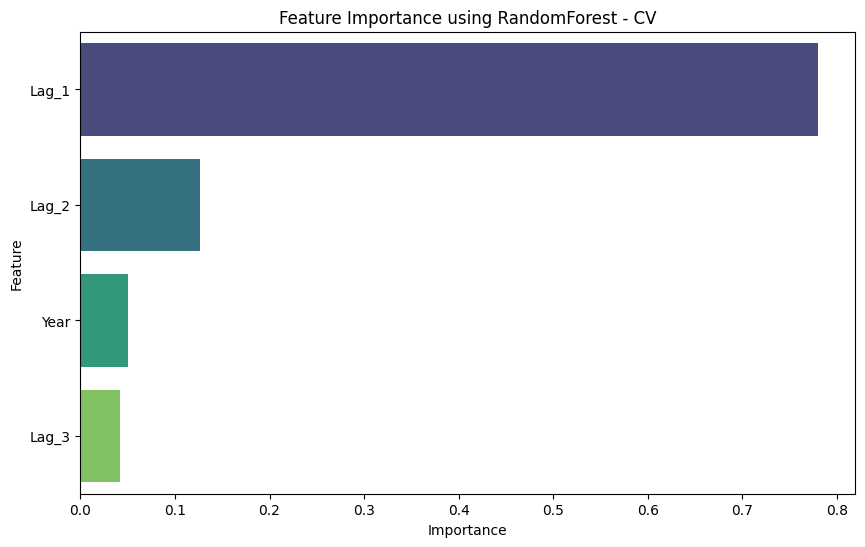

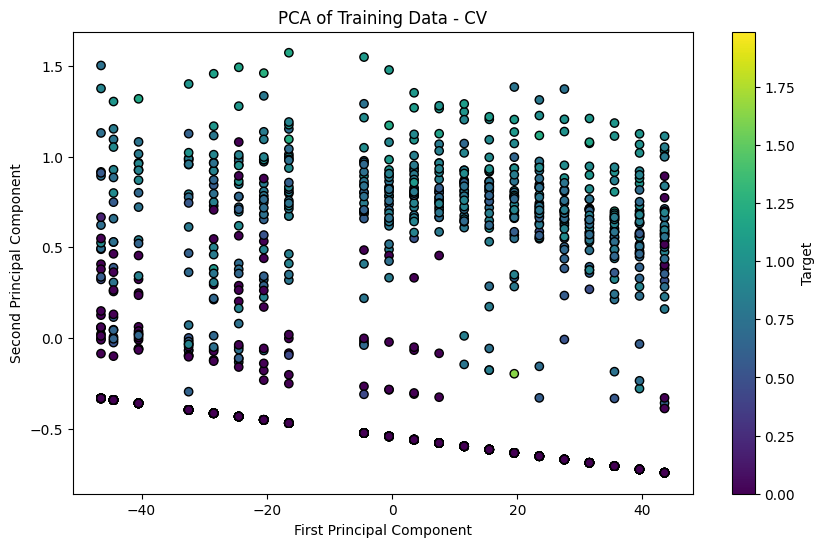


Stationarity Test and Rolling Statistics for Target Variable:
Results of Dickey-Fuller Test:
Test Statistic: -9.111272704755125
p-value: 3.3943857339876918e-15
Critical Values:
   1%: -3.434944046599697
   5%: -2.863568954302161
   10%: -2.5678502032578696


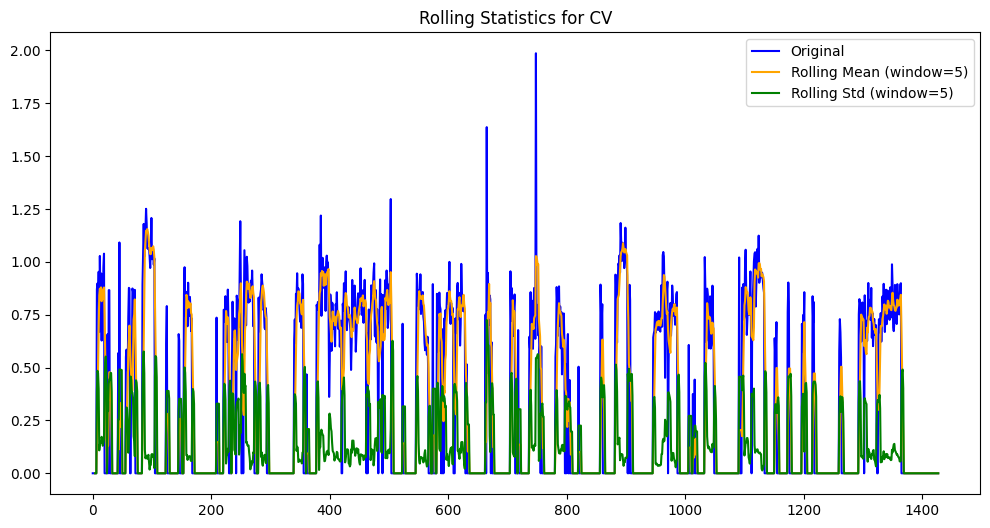


Autocorrelation and Partial Autocorrelation for Target Variable:


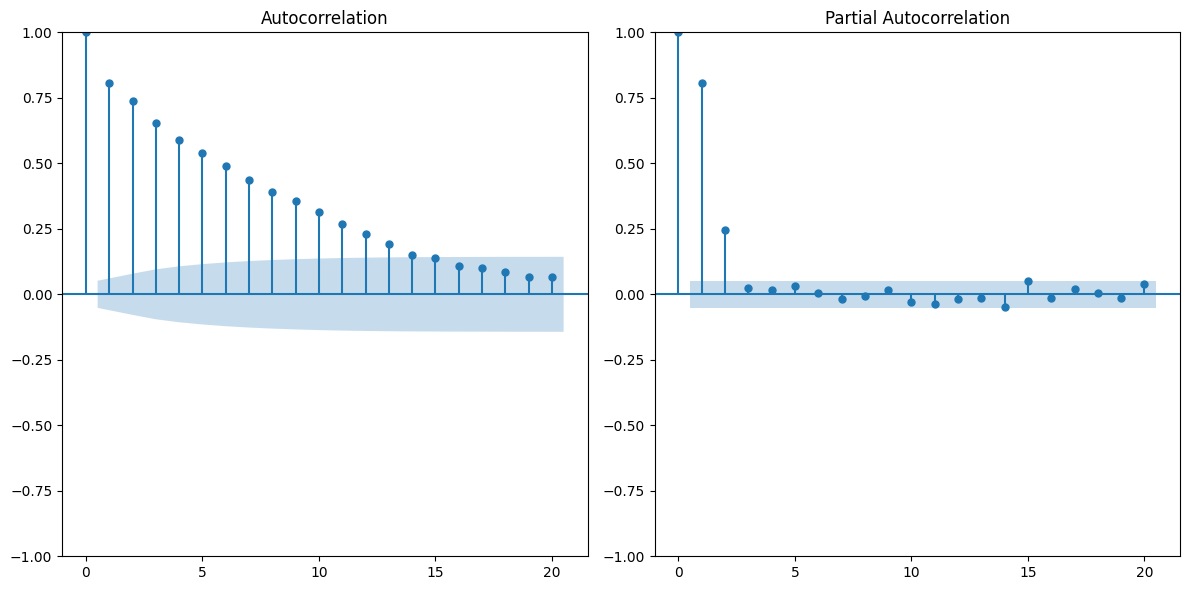


Training CatBoost...
CatBoost - Best Params: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05}
CatBoost - MSE: 0.02636334996766869, R2: 0.8276593393897265

Training Random Forest...
Random Forest - Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - MSE: 0.04703835250434958, R2: 0.692504148578983

Training Decision Tree...
Decision Tree - Best Params: {'max_depth': 5, 'min_samples_split': 5}
Decision Tree - MSE: 0.14122151952558754, R2: 0.07681648966181709

Training k-NN Regression...
k-NN Regression - Best Params: {'n_neighbors': 5, 'weights': 'uniform'}
k-NN Regression - MSE: 0.043948629661579294, R2: 0.7127020701814619

Training XGBoost...
XGBoost - Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
XGBoost - MSE: 0.039016056617397814, R2: 0.744946944144186

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` t

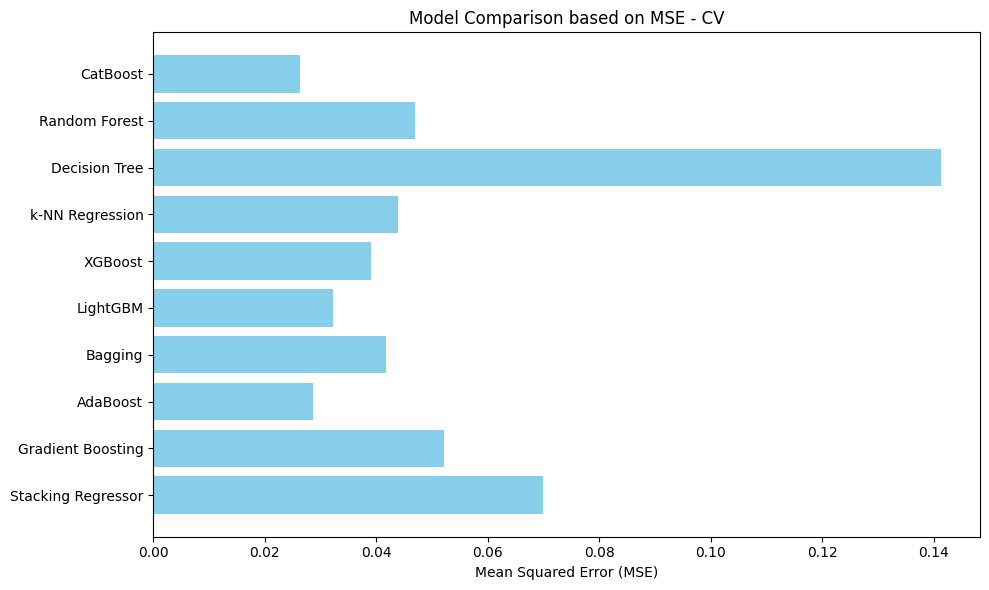

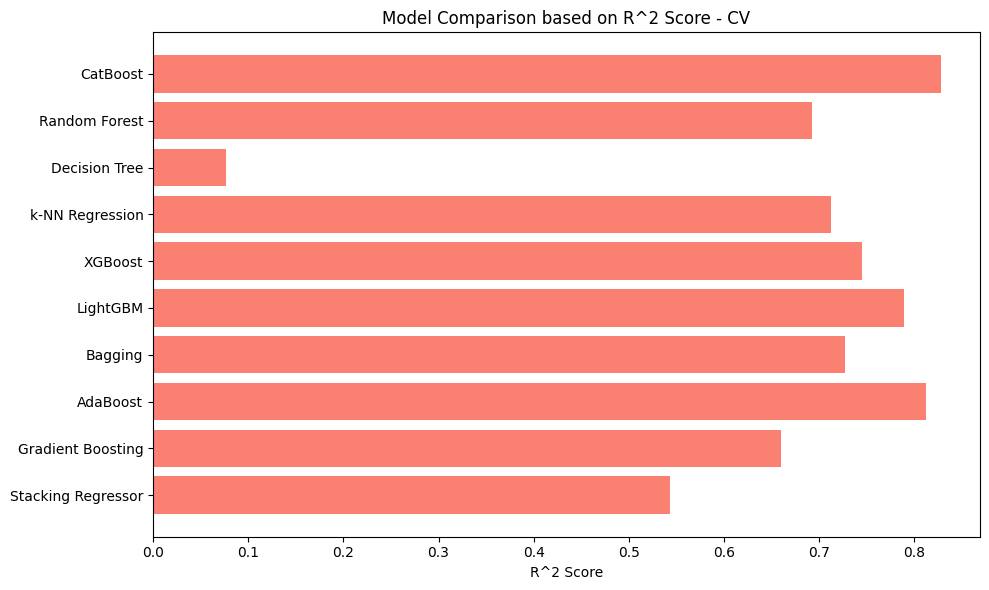


Best model for 'CV' is: CatBoost
Sport with the most non-zero 'CV' values: Athletics
Final selected sport for 'CV': Athletics


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Import models and tools
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import (
    RandomForestRegressor, BaggingRegressor,
    AdaBoostRegressor, GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# ==========================================
# Data Reading and Initial Preparation
# ==========================================
# Initialize a dictionary to store the best models for each parameter
all_best_estimators = {}
# Read the data
df = pd.read_csv("not_final3.csv")

# List of parameters to process
parameters = ['drug', 'equity','popularity', 'normalizedcountry', 'CV']

# For 'normalized_country' and 'CV', we need to split at 2000 instead of 2004
split_years = {
    'normalized_country': 2000,
    'CV': 2000
}

# For other parameters, split at 2004
default_split_year = 2004

# For 'drug', missing values should be filled with 0
fill_missing_with_zero = ['drug']

# Dictionary to store the best estimator for each parameter
best_estimators = {}

# Iterate over each parameter
for parameter in parameters:
    print(f"\nProcessing parameter: {parameter}")
    print("=" * 50)
    
    # ==========================================
    # Data Preparation
    # ==========================================
    
    # Filter columns for the current parameter
    param_columns = [col for col in df.columns if col.split('_')[0] == parameter]
    
    # Include 'Sport_-1' column as an identifier if it exists
    if 'Sport_-1' in df.columns:
        param_columns.insert(0, 'Sport_-1')
    
    df_param = df[param_columns]
    
    # Remove 'Sport_-1' column (identifier)
    if 'Sport_-1' in df_param.columns:
        df_param = df_param.rename(columns={'Sport_-1': 'Sport'})
    else:
        df_param['Sport'] = df['Sport_-1']
    
    # Melt the data to long format
    melted_data = df_param.reset_index().melt(id_vars=['index', 'Sport'], var_name='Year', value_name='Target')
    
    # Extract the year from the 'parameter_year' format
    melted_data['Year'] = melted_data['Year'].str.extract('(\d+)').astype(int)
    
    # Handle missing values
    if parameter in fill_missing_with_zero:
        # Fill missing Target values with 0
        melted_data['Target'] = melted_data['Target'].fillna(0)
    else:
        # For other parameters, fill missing values with -1
        melted_data['Target'] = melted_data['Target'].fillna(-1)
    
    # Sort by index and Year
    melted_data = melted_data.sort_values(by=['index', 'Year']).reset_index(drop=True)
    
    # Function to create rolling window lags
    def create_lags(group):
        group['Lag_1'] = group['Target'].shift(1, fill_value=-1)
        group['Lag_2'] = group['Target'].shift(2, fill_value=-1)
        group['Lag_3'] = group['Target'].shift(3, fill_value=-1)
        return group
    
    # Apply rolling window logic for each sport (index)
    result = melted_data.groupby('index').apply(create_lags).reset_index(drop=True)
    
    # Define function to fill missing lags
    def fill_lags(row):
        # Fill missing lags using available lower lags
        for lag in ['Lag_1', 'Lag_2', 'Lag_3']:
            if row[lag] == -1:
                lower_lags = [l for l in ['Lag_1', 'Lag_2', 'Lag_3'] if row[l] != -1 and l > lag]
                if lower_lags:
                    row[lag] = row[lower_lags[0]]  # Use the most recent lower lag value
        return row
    
    # Apply the lag-filling function to each group
    result = result.groupby('index').apply(lambda group: group.apply(fill_lags, axis=1)).reset_index(drop=True)
    
    # Drop rows with -1 in any of the columns: 'Target', 'Lag_1', 'Lag_2', 'Lag_3'
    cleaned_result = result[(result[['Target', 'Lag_1', 'Lag_2', 'Lag_3']] != -1).all(axis=1)].reset_index(drop=True)
    
    # Print the head of the cleaned_result DataFrame
    print("\nData after cleaning and before modeling:")
    print(cleaned_result.head())
    
    # Determine split year
    split_year = split_years.get(parameter, default_split_year)
    
    # Divide the DataFrame into two based on the Year column
    before_split = cleaned_result[cleaned_result['Year'] < split_year].reset_index(drop=True)
    after_or_equal_split = cleaned_result[cleaned_result['Year'] >= split_year].reset_index(drop=True)
    
    # ==========================================
    # EDA (Exploratory Data Analysis)
    # ==========================================
    
    print(f"\nData before {split_year}: {before_split.shape}")
    print(f"Data from {split_year} onwards: {after_or_equal_split.shape}")
    
    # Drop 'index' and 'Sport' columns for modeling
    X_train = before_split.drop(['Target', 'index', 'Sport'], axis=1)
    y_train = before_split['Target']
    
    X_test = after_or_equal_split.drop(['Target', 'index', 'Sport'], axis=1)
    y_test = after_or_equal_split['Target']
    
    # Visualize data
    def visualize_data(X, y, title=""):
        print(f"\n{title} - Descriptive Statistics")
        print(X.describe())
        print(f"\n{title} Target Variable - Descriptive Statistics")
        print(y.describe())
        
        plt.figure(figsize=(10, 6))
        plt.plot(y.values, label="Target")
        plt.title(f"{title} Target Variable for {parameter}")
        plt.legend()
        plt.show()
    
    # Visualizing train/test data
    visualize_data(X_train, y_train, "Training Data")
    visualize_data(X_test, y_test, "Test Data")
    
    # Pairplot
    combined_data = pd.concat([X_train, y_train], axis=1)
    sns.pairplot(combined_data, diag_kind='kde')
    plt.suptitle(f'Pair Plot for Features (Train Data) - {parameter}', y=1.02)
    plt.show()
    
    # Correlation Heatmap
    plt.figure(figsize=(10, 6))
    correlation = combined_data.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f"Feature Correlation Heatmap - {parameter}")
    plt.show()
    
    # Feature Importance using RandomForest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Feature Importance using RandomForest - {parameter}')
    plt.show()
    
    # Principal Component Analysis (PCA) to reduce dimensions and visualize
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
    plt.title(f'PCA of Training Data - {parameter}')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(label='Target')
    plt.show()
    
    # ==========================================
    # Time Series Analysis (for Rolling Windows)
    # ==========================================
    
    # Rolling Mean and Standard Deviation
    def plot_rolling_stats(series, window=5, title="Rolling Mean and Standard Deviation"):
        rolling_mean = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        
        plt.figure(figsize=(12, 6))
        plt.plot(series.values, label='Original', color='blue')
        plt.plot(rolling_mean.values, label=f'Rolling Mean (window={window})', color='orange')
        plt.plot(rolling_std.values, label=f'Rolling Std (window={window})', color='green')
        plt.legend(loc='best')
        plt.title(title)
        plt.show()
    
    # Augmented Dickey-Fuller Test for Stationarity
    def test_stationarity(series, window=5):
        print(f"Results of Dickey-Fuller Test:")
        result = adfuller(series)
        print(f"Test Statistic: {result[0]}")
        print(f"p-value: {result[1]}")
        print(f"Critical Values:")
        for key, value in result[4].items():
            print(f"   {key}: {value}")
                
        plot_rolling_stats(series, window, title=f"Rolling Statistics for {parameter}")
            
    # Autocorrelation and Partial Autocorrelation
    def plot_acf_pacf(series, lags=20):
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plot_acf(series, lags=lags, ax=plt.gca(), title="Autocorrelation")
        plt.subplot(122)
        plot_pacf(series, lags=lags, ax=plt.gca(), title="Partial Autocorrelation")
        plt.tight_layout()
        plt.show()
    
    print("\nStationarity Test and Rolling Statistics for Target Variable:")
    test_stationarity(y_train)
    
    print("\nAutocorrelation and Partial Autocorrelation for Target Variable:")
    plot_acf_pacf(y_train)
    
    # ==========================================
    # Model Training and Evaluation
    # ==========================================
    
    # Initialize list to store results
    results = []
    
    # Define the list of models and their parameter grids
    models = [
        {
            'name': 'CatBoost',
            'estimator': CatBoostRegressor(random_state=42, verbose=0),
            'param_grid': {
                'depth': [4, 6],
                'learning_rate': [0.01, 0.05],
                'iterations': [100]
            }
        },
        {
            'name': 'Random Forest',
            'estimator': RandomForestRegressor(random_state=42),
            'param_grid': {
                'n_estimators': [50, 100],
                'max_depth': [None, 5],
                'min_samples_split': [2, 5]
            }
        },
        {
            'name': 'Decision Tree',
            'estimator': DecisionTreeRegressor(random_state=42),
            'param_grid': {
                'max_depth': [None, 5, 10],
                'min_samples_split': [2, 5]
            }
        },
        {
            'name': 'k-NN Regression',
            'estimator': KNeighborsRegressor(),
            'param_grid': {
                'n_neighbors': [3, 5],
                'weights': ['uniform', 'distance']
            }
        },
        {
            'name': 'XGBoost',
            'estimator': XGBRegressor(random_state=42, verbosity=0),
            'param_grid': {
                'n_estimators': [100],
                'max_depth': [3, 5],
                'learning_rate': [0.01, 0.05]
            }
        },
        {
            'name': 'LightGBM',
            'estimator': LGBMRegressor(random_state=42),
            'param_grid': {
                'num_leaves': [31, 50],
                'learning_rate': [0.01, 0.05],
                'n_estimators': [100]
            }
        },
        {
            'name': 'Bagging',
            'estimator': BaggingRegressor(random_state=42),
            'param_grid': {
                'n_estimators': [10, 50],
                'max_samples': [0.5, 1.0],
                'max_features': [0.5, 1.0]
            }
        },
        {
            'name': 'AdaBoost',
            'estimator': AdaBoostRegressor(random_state=42),
            'param_grid': {
                'n_estimators': [50, 100],
                'learning_rate': [0.01, 0.05, 1.0]
            }
        },
        {
            'name': 'Gradient Boosting',
            'estimator': GradientBoostingRegressor(random_state=42),
            'param_grid': {
                'n_estimators': [100],
                'learning_rate': [0.01, 0.05],
                'max_depth': [3, 5]
            }
        },
        # Removed SVR for time considerations
    ]
    
    # Loop over each model
    for model_dict in models:
        name = model_dict['name']
        estimator = model_dict['estimator']
        param_grid = model_dict['param_grid']
        
        print(f"\nTraining {name}...")
        
        # Set up GridSearchCV
        grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            scoring='neg_mean_squared_error'
        )
        
        # Fit the model
        grid_search.fit(X_train, y_train)
        
        # Retrieve the best parameters and estimator
        best_params = grid_search.best_params_
        best_estimator = grid_search.best_estimator_
        
        # Make predictions on the test set
        y_pred = best_estimator.predict(X_test)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{name} - Best Params: {best_params}")
        print(f"{name} - MSE: {mse}, R2: {r2}")
        
        # Store the results
        results.append({
            'Model': name,
            'Best Params': best_params,
            'MSE': mse,
            'R2': r2
        })
        
        # If parameter is 'CV', store the best estimator
        if parameter == 'CV':
            best_estimators[name] = best_estimator  # Store the best estimator for 'CV'
    
    # ==========================================
    # Training Stacking Regressor
    # ==========================================
    
    # Define base estimators for stacking
    estimators_list = [
        ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
        ('knn', KNeighborsRegressor(n_neighbors=5)),
        ('dt', DecisionTreeRegressor(max_depth=5, random_state=42))
    ]
    
    # Define the final estimator
    final_estimator = LinearRegression()
    
    # Create the Stacking Regressor
    stacking_model = StackingRegressor(
        estimators=estimators_list,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1
    )
    
    print("\nTraining Stacking Regressor...")
    
    # Define parameter grid for the stacking model
    param_grid = {
        'final_estimator__fit_intercept': [True, False]
    }
    
    # Set up GridSearchCV for the stacking model
    grid_search = GridSearchCV(
        estimator=stacking_model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error'
    )
    
    # Fit the stacking model
    grid_search.fit(X_train, y_train)
    
    # Retrieve best parameters and estimator
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_estimator.predict(X_test)
    
    # Evaluate the stacking model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Stacking Regressor - Best Params: {best_params}")
    print(f"Stacking Regressor - MSE: {mse}, R2: {r2}")
    
    # Store the results
    results.append({
        'Model': 'Stacking Regressor',
        'Best Params': best_params,
        'MSE': mse,
        'R2': r2
    })
    
    # If parameter is 'CV', store the stacking model estimator
    if parameter == 'CV':
        best_estimators['Stacking Regressor'] = best_estimator  # Store the best stacking estimator for 'CV'
    
    # ==========================================
    # Results Comparison
    # ==========================================
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    print("\nModel Evaluation Results:")
    print(results_df)
    
    # Plot MSE for each model
    plt.figure(figsize=(10, 6))
    plt.barh(results_df['Model'], results_df['MSE'], color='skyblue')
    plt.xlabel('Mean Squared Error (MSE)')
    plt.title(f'Model Comparison based on MSE - {parameter}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Plot R^2 scores for each model
    plt.figure(figsize=(10, 6))
    plt.barh(results_df['Model'], results_df['R2'], color='salmon')
    plt.xlabel('R^2 Score')
    plt.title(f'Model Comparison based on R^2 Score - {parameter}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # ==========================================
    # Model Selection for Each Parameter
    # ==========================================
    
    # Choose the best model based on R2 score
    best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
    print(f"\nBest model for '{parameter}' is: {best_model_name}")
    if parameter not in all_best_estimators:
        all_best_estimators[parameter] = {}
    all_best_estimators[parameter][best_model_name] = best_estimator

    best_model = all_best_estimators[parameter][best_model_name]

    # Identify the sport with the most non-zero values for the current parameter
    non_zero_counts = cleaned_result.groupby('Sport')['Target'].apply(lambda x: (x != 0).sum())
    most_data_sport = non_zero_counts.idxmax()
    print(f"Sport with the most non-zero '{parameter}' values: {most_data_sport}")

    # Check for test data availability for the selected sport
    sport_index = cleaned_result[cleaned_result['Sport'] == most_data_sport]['index'].unique()[0]
    sport_test_data = after_or_equal_split[after_or_equal_split['index'] == sport_index].reset_index(drop=True)

    if sport_test_data.empty:
        print(f"No test data available for sport: {most_data_sport}. Selecting another sport.")
        
        # Select another sport with valid test data
        valid_sports = after_or_equal_split['Sport'].unique()
        non_zero_counts = non_zero_counts[non_zero_counts.index.isin(valid_sports)]
        most_data_sport = non_zero_counts.idxmax()
        print(f"New sport selected for '{parameter}': {most_data_sport}")
        
        sport_index = cleaned_result[cleaned_result['Sport'] == most_data_sport]['index'].unique()[0]
        sport_test_data = after_or_equal_split[after_or_equal_split['index'] == sport_index].reset_index(drop=True)

    print(f"Final selected sport for '{parameter}': {most_data_sport}")

    # Prepare test data for the selected sport
    X_sport_test = sport_test_data.drop(['Target', 'index', 'Sport'], axis=1)
    y_sport_test = sport_test_data['Target']

    # Make predictions using the best model
    y_sport_pred = best_model.predict(X_sport_test)

    # Store predictions and actual values for later use or plotting
    predictions_df = pd.DataFrame({
        'Actual': y_sport_test.values,
        'Predicted': y_sport_pred
    })

   



In [11]:
# ===================================================
# Using the Best Models to Predict CV Values for a Specified Sport
# ===================================================

import pandas as pd
import matplotlib.pyplot as plt

# Assuming all necessary libraries are already imported
# and the previous code has been executed, including:
# - Data preparation for 'CV' parameter
# - Training of models and selection of the best models for each type

# Function to select and analyze a specific sport
def analyze_sport(sport_name=None):
    # If no sport specified, choose the sport with most non-zero 'CV' values
    if not sport_name:
        non_zero_counts = cleaned_result.groupby('Sport')['Target'].apply(lambda x: (x != 0).sum())
        sport_name = non_zero_counts.idxmax()
    
    print(f"Analyzing sport: {sport_name}")

    # Get all data for the selected sport
    sport_data = melted_data[melted_data['Sport'] == sport_name].reset_index(drop=True)
    
    # Sort the data by Year
    sport_data = sport_data.sort_values(by='Year').reset_index(drop=True)
    
    # Reprocess the rolling windows in the same manner as during training
    # Create lags
    sport_data = create_lags(sport_data)
    
    # Fill missing lags
    sport_data = sport_data.apply(fill_lags, axis=1)
    
    # Prepare data for prediction
    # Keep rows where 'Lag_1', 'Lag_2', 'Lag_3' are not -1
    prediction_data = sport_data[(sport_data[['Lag_1', 'Lag_2', 'Lag_3']] != -1).all(axis=1)].reset_index(drop=True)
    
    # Features and actual target values
    X_sport = prediction_data[['Year', 'Lag_1', 'Lag_2', 'Lag_3']]
    y_sport_actual = prediction_data['Target']
    years = prediction_data['Year']

    # Loop through all best models
    for model_name, best_model in best_estimators.items():
        print(f"\nUsing Best Model: {model_name}")
        
        # Ensure X_sport columns match model's training features
        if hasattr(best_model, 'feature_names_'):
            required_features = best_model.feature_names_
        else:
            required_features = X_sport.columns
        
        X_sport_corrected = X_sport[required_features]
        
        # Predict using the best model
        y_sport_pred = best_model.predict(X_sport_corrected)
        
        # Create a DataFrame for plotting
        plot_df = pd.DataFrame({
            'Year': years,
            'Actual': y_sport_actual,
            'Predicted': y_sport_pred
        })
        
        # Plot the actual and predicted CV values over the years
        plt.figure(figsize=(12, 6))
        plt.plot(plot_df['Year'], plot_df['Actual'], marker='o', label='Actual CV', color='blue')
        plt.plot(plot_df['Year'], plot_df['Predicted'], marker='x', linestyle='--', label=f'Predicted CV ({model_name})', color='orange')
        plt.title(f'Actual vs. Predicted CV Values over Years for {sport_name} ({model_name})')
        plt.xlabel('Year')
        plt.ylabel('CV Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Analyzing sport: Athletics

Using Best Model: CatBoost

Using Best Model: Random Forest

Using Best Model: Decision Tree

Using Best Model: k-NN Regression

Using Best Model: XGBoost

Using Best Model: LightGBM

Using Best Model: Bagging

Using Best Model: AdaBoost

Using Best Model: Gradient Boosting

Using Best Model: Stacking Regressor


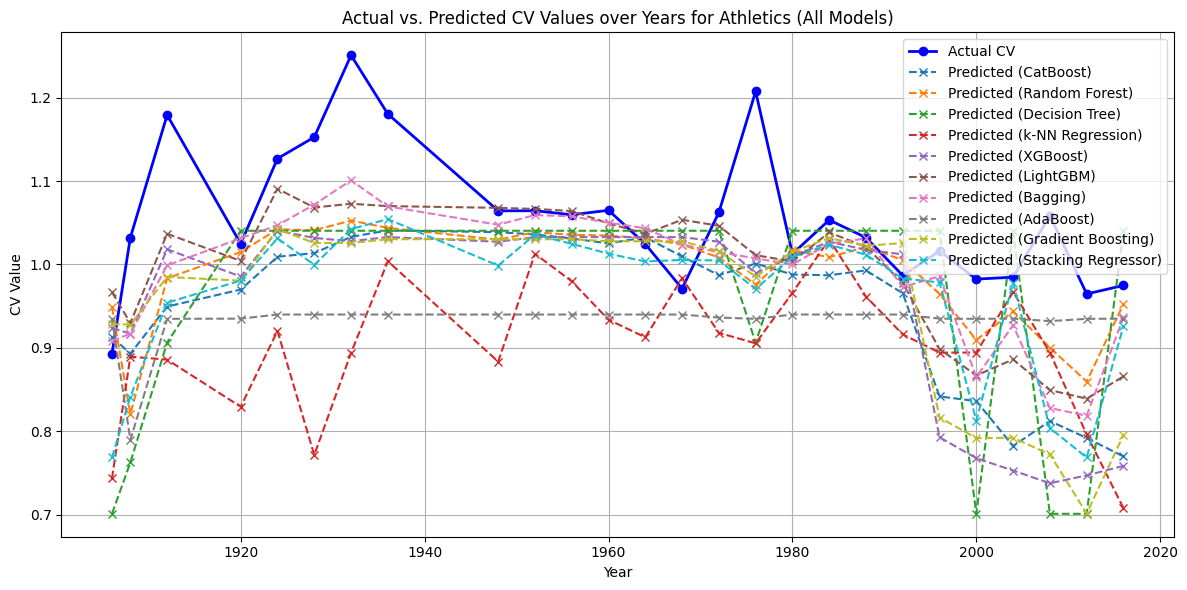

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to select and analyze a specific sport with combined visualization
def analyze_sport_combined(sport_name=None):
    # If no sport specified, choose the sport with most non-zero 'CV' values
    if not sport_name:
        non_zero_counts = cleaned_result.groupby('Sport')['Target'].apply(lambda x: (x != 0).sum())
        sport_name = non_zero_counts.idxmax()
    
    print(f"Analyzing sport: {sport_name}")

    # Get all data for the selected sport
    sport_data = melted_data[melted_data['Sport'] == sport_name].reset_index(drop=True)
    
    # Sort the data by Year
    sport_data = sport_data.sort_values(by='Year').reset_index(drop=True)
    
    # Reprocess the rolling windows in the same manner as during training
    # Create lags
    sport_data = create_lags(sport_data)
    
    # Fill missing lags
    sport_data = sport_data.apply(fill_lags, axis=1)
    
    # Prepare data for prediction
    # Keep rows where 'Lag_1', 'Lag_2', 'Lag_3' are not -1
    prediction_data = sport_data[(sport_data[['Lag_1', 'Lag_2', 'Lag_3']] != -1).all(axis=1)].reset_index(drop=True)
    
    # Features and actual target values
    X_sport = prediction_data[['Year', 'Lag_1', 'Lag_2', 'Lag_3']]
    y_sport_actual = prediction_data['Target']
    years = prediction_data['Year']

    # Initialize a DataFrame to store predictions for all models
    combined_df = pd.DataFrame({'Year': years, 'Actual': y_sport_actual})
    
    # Loop through all best models and store predictions
    for model_name, best_model in best_estimators.items():
        print(f"\nUsing Best Model: {model_name}")
        
        # Ensure X_sport columns match model's training features
        if hasattr(best_model, 'feature_names_'):
            required_features = best_model.feature_names_
        else:
            required_features = X_sport.columns
        
        X_sport_corrected = X_sport[required_features]
        
        # Predict using the best model
        combined_df[f'Predicted ({model_name})'] = best_model.predict(X_sport_corrected)
    
    # ==========================================
    # Combined Plot
    # ==========================================
    
    plt.figure(figsize=(12, 6))
    
    # Plot the actual values
    plt.plot(combined_df['Year'], combined_df['Actual'], marker='o', label='Actual CV', color='blue', linewidth=2)
    
    # Plot the predicted values from each model
    for col in combined_df.columns[2:]:
        plt.plot(combined_df['Year'], combined_df[col], linestyle='--', marker='x', label=col)
    
    plt.title(f'Actual vs. Predicted CV Values over Years for {sport_name} (All Models)')
    plt.xlabel('Year')
    plt.ylabel('CV Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# To analyze the default sport (with most non-zero CV values) and combined plot
analyze_sport_combined()


Analyzing sport: Gymnastics

Using Best Model: CatBoost

Using Best Model: Random Forest

Using Best Model: Decision Tree

Using Best Model: k-NN Regression

Using Best Model: XGBoost

Using Best Model: LightGBM

Using Best Model: Bagging

Using Best Model: AdaBoost

Using Best Model: Gradient Boosting

Using Best Model: Stacking Regressor


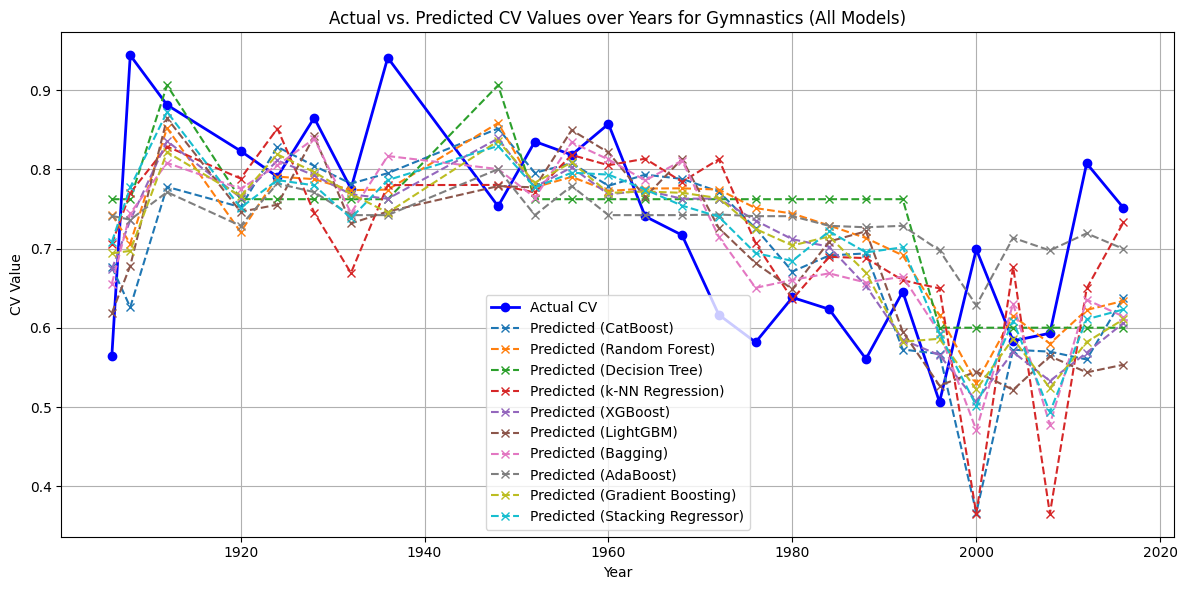

In [10]:
analyze_sport_combined('Gymnastics')